In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)

import warnings
warnings.simplefilter('ignore')

# general purpose packages
import pandas as pd
import swifter # for parallelizing some pandas functions
import numpy as np
import os
import json
import time
import re
import csv
import subprocess
import sys
import itertools

import scipy.stats as stats
import statsmodels.stats as smstats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# for anomaly detection
from sklearn.ensemble import IsolationForest
import jenkspy

# for scoring
from scipy.stats import dirichlet
from scipy import integrate

import umap
import rpy2

from multiprocessing import Process, Manager, Pool
import multiprocessing
from functools import partial

from collections import Counter

import seaborn as sns; sns.set()

import matplotlib
matplotlib.style.use('seaborn')
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['backend'] = "Qt5Agg"
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from IPython.display import display, Image

from adjustText import adjust_text
import builtins
%matplotlib inline

import textwrap

# for normalization
from sklearn.linear_model import QuantileRegressor

# for custom clustering
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from matplotlib.patches import Rectangle

# for selecting combinations
from itertools import combinations

# for working with yaml files
import ruamel.yaml

In [2]:
def get_pvalue_star(pval, thr=0.05):
    if thr == 0.05:
        if pval < 0.001:
            return "***"
        elif pval < 0.01:
            return "**"
        elif pval < 0.05:
            return "*"
        else:
            return "ns"
    elif thr == 0.1:
        if pval < 0.001:
            return "***"
        elif pval < 0.01:
            return "**"
        elif pval < 0.1:
            return "*"
        else:
            return "ns"

from statsmodels.stats import proportion as smprop


def get_group_percentages(df, x_group, hue, sum_by=None):
    if sum_by is None:
        grouped = df.groupby([hue], sort=False)
        counts = grouped[x_group].value_counts(sort=False)
        counts = pd.DataFrame(counts).rename(columns={x_group: "count"}).reset_index()

        counts_sum = counts[[hue, "count"]].groupby(hue).sum()
        counts_sum.reset_index(inpexperlace=True)
        counts_sum.rename(columns={"count": "countgroup"}, inplace=True)

        data = pd.merge(counts, counts_sum, how="left", left_on=hue, right_on=hue)
        data["percentage"] = data["count"] / data["countgroup"] * 100
    else:
        grouped = (
            df[[x_group, hue, sum_by]].groupby([hue, x_group], sort=False).agg(np.sum)
        )
        grouped.reset_index(inplace=True)

        counts = grouped[[hue, sum_by]].groupby(hue).sum()
        counts.reset_index(inplace=True)
        counts = counts.rename(columns={sum_by: sum_by + "_sumgroup"})

        data = pd.merge(grouped, counts, how="left", left_on=hue, right_on=hue)
        data["percentage"] = data[sum_by] / data[sum_by + "_sumgroup"] * 100

    return data.sort_values(by=[hue, x_group])


def add_errorbars(ax_item, x, y, yerr):
    yerr_0 = [0] * len(yerr)
    yerr = [yerr_0, yerr]
    (_, caps, _) = ax_item.errorbar(
        x=x, y=y, yerr=yerr, capsize=3, fmt="none", color="black"
    )
    for cap in caps:
        cap.set_markeredgewidth(1)


def get_proportion_ci(data_percentage, data_observcount, z):
    return (
        100
        * z
        * ((data_percentage / 100) * (1 - data_percentage / 100) / (data_observcount))
        ** 0.5
    )


def percentage_plot(
    dataset,
    x_group,
    hue,
    axes_pos=0,
    legend_loc="upper right",
    cleanlook=False,
    alpha=0.05,
    palette="hls",
    dodge=0.52,
    xlabel="",
    ylabel="",
    legend_title="",
    exclude_x_group="",
    point_scale=0,
    edgecolor="black",
    linewidth=1,
):

    data = get_group_percentages(dataset, x_group, hue)

    if exclude_x_group != "":
        data = data.loc[~data[x_group].isin(exclude_x_group)]

    palette_n = len(data[[hue]].drop_duplicates())

    if axes_pos != 0:
        ax0 = sns.pointplot(
            x=x_group,
            scale=point_scale,
            y="percentage",
            hue=hue,
            data=data,
            ax=axes_pos,
            palette=sns.color_palette(palette, palette_n),
            #                          order = order,
            dodge=dodge,
            join=False,
        )
        ax0 = sns.barplot(
            x=x_group,
            y="percentage",
            hue=hue,
            data=data,
            ax=axes_pos,
            palette=sns.color_palette(palette, palette_n),
            linewidth=linewidth,
            edgecolor=edgecolor,
            #                          order = order
        )
    else:
        ax0 = sns.pointplot(
            x=x_group,
            scale=point_scale,
            y="percentage",
            hue=hue,
            data=data,
            palette=sns.color_palette(palette, palette_n),
            #                          order = order,
            dodge=dodge,
            join=False,
        )
        ax0 = sns.barplot(
            x=x_group,
            y="percentage",
            hue=hue,
            data=data,
            palette=sns.color_palette(palette, palette_n),
            linewidth=linewidth,
            edgecolor=edgecolor,
            #                          order = order
        )
    x_coords = []
    y_coords = []
    for point_pair in ax0.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    try:
        add_errorbars(
            ax0,
            x=x_coords,
            y=y_coords,
            yerr=(
                data.apply(
                    lambda x: smprop.proportion_confint(
                        count=x["count"],
                        nobs=x["countgroup"],
                        alpha=alpha,
                        method="normal",
                    )[1],
                    1,
                )
                - data["percentage"] / 100
            )
            * 100,
        )
    except Exception as e:
        print(e)

    if legend_loc == None:
        legend = ax0.legend()
        legend.remove()
    elif legend_loc == "outside":
        leg_handles = ax0.get_legend_handles_labels()[0][
            len(data[hue].drop_duplicates()) :
        ]
        ax0.legend(
            leg_handles,
            list(data[hue].drop_duplicates().sort_values()),
            bbox_to_anchor=(1.05, 1),
            loc=2,
            title=legend_title,
            borderaxespad=0.0,
        )
    else:
        leg_handles = ax0.get_legend_handles_labels()[0][
            len(data[hue].drop_duplicates()) :
        ]
        ax0.legend(
            leg_handles,
            list(data[hue].drop_duplicates().sort_values()),
            title=legend_title,
            loc=legend_loc,
        )

    if cleanlook:
        ax0.set(ylabel="", xlabel="")
        ax0.legend_.remove()
    if ylabel != "":
        ax0.set(ylabel=ylabel)
    if xlabel != "":
        ax0.set(xlabel=xlabel)
    return ax0

In [3]:
# paths to subdirectories
subdirs = {}

subdirs['main_project_dir'] = '/scicore/home/zavolan/GROUP/StefanieCLIP/'
subdirs['wf_dir'] = '/scicore/home/zavolan/mirono0000/Projects/bCLIP/bclip_workflow/'

subdirs['zarp_dir'] = '/scicore/home/zavolan/mirono0000/libs/zarp/'
subdirs['htsinfer_dir'] = '/scicore/home/zavolan/mirono0000/libs/htsinfer/'
subdirs['zarp_config_dir'] = subdirs['zarp_dir']+'config/'

subdirs['mouse_annotation_dir'] = '/scicore/home/zavolan/GROUP/Genomes/mus_musculus/'
subdirs['human_annotation_dir'] = '/scicore/home/zavolan/GROUP/Genomes/homo_sapiens/'

# shared project folder 
subdirs['shared_project_dir'] = subdirs['main_project_dir']+'aleksei/'
subdirs['temp_dir'] = subdirs['shared_project_dir']+'temp_dir/'
subdirs['slurm_dir'] = subdirs['temp_dir']+'slurm/'
subdirs['scripts_dir'] = subdirs['shared_project_dir']+'scripts/'
subdirs['figures_dir'] = subdirs['shared_project_dir']+'figures/'
subdirs['tables_dir'] = subdirs['shared_project_dir']+'tables/'

subdirs['fastq_dir'] = subdirs['shared_project_dir']+'input_fastq/'
subdirs['metadata_dir'] = subdirs['shared_project_dir']+'metadata/'
subdirs['wf_output_dir'] = subdirs['shared_project_dir']+'output/'

# paths to files
file_paths = {}
### genome annotation files
file_paths['mouse_genome_file'] = subdirs['mouse_annotation_dir']+'GRCm39.primary_assembly.genome.fa'
file_paths['mouse_annotation_file'] = subdirs['mouse_annotation_dir']+'gencode.vM32.annotation.gtf'
file_paths['mouse_RNAcentral_annotation_file'] = subdirs['mouse_annotation_dir']+'mus_musculus.GRCm39.gff3.gz'
file_paths['mouse_FeatureCounts_gtf_file'] = subdirs['mouse_annotation_dir']+'exonic_segments.gtf'

file_paths['mouse_prot_coding_gtf'] = subdirs['mouse_annotation_dir']+'coding.gencode.vM32.annotation.gtf'
file_paths['mouse_collapsed_prot_coding_gtf'] = subdirs['mouse_annotation_dir']+'collapsed.coding.gencode.vM32.annotation.gtf'

file_paths['mouse_enriched_annotation_file'] = subdirs['mouse_annotation_dir']+'enriched.gencode.vM32.annotation.gtf' # added RNA species from RNA central
file_paths['mouse_collapsed_enriched_annotation_file'] = subdirs['mouse_annotation_dir']+'collapsed.enriched.gencode.vM32.annotation.gtf'

file_paths['human_genome_file'] = subdirs['human_annotation_dir']+'GRCh38.primary_assembly.genome.fa'
file_paths['human_annotation_file'] = subdirs['human_annotation_dir']+'hg38_v42/gencode.v42.annotation.gtf'
file_paths['human_RNAcentral_annotation_file'] = subdirs['human_annotation_dir']+'hg38_v42/homo_sapiens.GRCh38.gff3.gz'
file_paths['human_FeatureCounts_gtf_file'] = subdirs['human_annotation_dir']+'hg38_v42/exonic_segments.gtf'

file_paths['human_enriched_annotation_file'] = subdirs['human_annotation_dir']+'hg38_v42/enriched.gencode.v42.annotation.gtf'

file_paths['htsinfer_transcripts_file'] = '/scicore/home/zavolan/GROUP/Genomes/htsinfer_deduplicated_transcripts.fasta'

### control data
file_paths['control_metadata_file_1'] = subdirs['metadata_dir']+'SRA_CONTROL_DATA_1.tsv'
file_paths['control_metadata_file_2'] = subdirs['metadata_dir']+'SRA_CONTROL_DATA_2.tsv'

os.system('mkdir -p '+' '.join(list(subdirs.values()))) # create all subdirs

0

# bCLIP analysis

## Check that NRDE bCLIP matches the NRDE from original paper and separates from Ints bCLIPs

In [4]:
experimental_bCLIP_samples = pd.read_csv(subdirs['metadata_dir']+'experimental_bCLIP_samples.tsv',delimiter="\t",index_col=None,header=0)
public_bCLIP_and_ChipSeq_samples = pd.read_csv(subdirs['metadata_dir']+'public_bCLIP_and_ChipSeq_samples.tsv',delimiter="\t",index_col=None,header=0)

bclip_experiments_to_analyze = ['RBC_exp17','RBC_exp18','Ints11C_replicate5','Ints11C_replicate6','Ints10N_replicate1','Ints10N_replicate2']

experimental_bCLIP_samples['type'] = 'in-house'
public_bCLIP_and_ChipSeq_samples['type'] = 'public'

samples_to_analyze_df = pd.concat([experimental_bCLIP_samples.loc[experimental_bCLIP_samples['name'].isin(bclip_experiments_to_analyze)][['name','type','condition_name']],
                                  public_bCLIP_and_ChipSeq_samples.loc[(public_bCLIP_and_ChipSeq_samples['batch']=='public_bCLIP_mESC')&(
                                      public_bCLIP_and_ChipSeq_samples['condition_name']!='Mtrex')][['name','type','condition_name']]]).reset_index(drop=True)
samples_to_analyze_df['condition'] = samples_to_analyze_df['condition_name']+'; '+samples_to_analyze_df['type']

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)
plot_specification['color'] = ['darkturquoise','olive','grey','orange','blue','gold','green','greenyellow']

samples_to_analyze_df = samples_to_analyze_df[['name','condition']].rename(columns = {'name':'sample'})

In [5]:
i = 0
a = []
for index,row in samples_to_analyze_df.iterrows():
    sample = row['sample']
    file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/exon_intron/'+sample+'.wd_counts.tsv'

    if i==0:
        tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols=[0,1,2,3,5])
        tmp[['chr','strand']] = tmp[['chr','strand']].astype('category')
        tmp = tmp.rename(columns = {'uniquely_mapped;0':sample})
    else:
        tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols=[5])
        tmp = tmp.rename(columns = {'uniquely_mapped;0':sample})
    a.append(tmp)
    print(sample+' done')
    i=i+1

Ints11C_replicate5 done
Ints11C_replicate6 done
Ints10N_replicate1 done
Ints10N_replicate2 done
RBC_exp17 done
RBC_exp18 done
SRR15070630 done
SRR15070631 done
SRR15070632 done
SRR15070633 done
SRR15070635 done
SRR15070636 done
SRR15070639 done
SRR15070640 done
SRR15070642 done
SRR15070643 done


In [6]:
wd_counts = pd.concat(a,axis=1)
sample_list = list(samples_to_analyze_df['sample'])
wd_counts['sum'] = wd_counts[sample_list].sum(1)
wd_counts = wd_counts.loc[wd_counts['sum']>0].reset_index(drop=True)
wd_counts[sample_list] = wd_counts[sample_list]+1 # pseudocount of 1
# convert to CPM
wd_counts[sample_list] = ((wd_counts[sample_list])*(10**6)).div(wd_counts[sample_list].sum())
wd_counts[sample_list] = np.log2(wd_counts[sample_list])

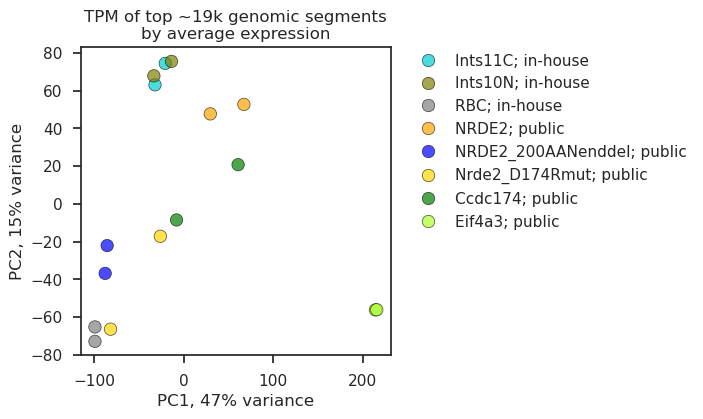

In [20]:
x = (wd_counts.loc[wd_counts['sum']>wd_counts['sum'].quantile(0.98)][sample_list].values).transpose()
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf['sample'] = sample_list

principalDf = pd.merge(principalDf,samples_to_analyze_df,how='left',on='sample')

x_feature,y_feature = 'PC1','PC2'
bw_adjust = 1.75
alpha_param, s_param = 0.7, 80

hue='condition'
hue_order = list(plot_specification[hue])
palette = list(plot_specification['color'])

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(4,4))

ax = sns.scatterplot(data = principalDf,x=x_feature,y=y_feature,s=s_param,alpha=alpha_param,edgecolor='black',linewidth=0.5,
                     hue=hue,hue_order = hue_order, palette = palette)
ax.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.0,title='')
ax.set(xlabel = 'PC1, '+str(int(np.round(pca.explained_variance_ratio_[0]*100,0)))+'% variance')
ax.set(ylabel = 'PC2, '+str(int(np.round(pca.explained_variance_ratio_[1]*100,0)))+'% variance')
ax.set(title = 'TPM of top ~'+str(int(np.shape(x)[1]/1000))+'k genomic segments\nby average expression')

ax.tick_params(bottom=True,left=True)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'Reproducibility/', shell=True)
fig.savefig(subdirs['figures_dir']+'Reproducibility/PCA_without_in_house_NRDE2_and_Mtrex.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'Reproducibility/PCA_without_in_house_NRDE2_and_Mtrex.pdf',bbox_inches='tight',dpi=600)

## Make nice metaplots for Ints11C, Ints10N, RBC, eCLIP (Hela)

In [58]:
experimental_bCLIP_samples = pd.read_csv(subdirs['metadata_dir']+'experimental_bCLIP_samples.tsv',delimiter="\t",index_col=None,header=0)
public_bCLIP_and_ChipSeq_samples = pd.read_csv(subdirs['metadata_dir']+'public_bCLIP_and_ChipSeq_samples.tsv',delimiter="\t",index_col=None,header=0)

experiments_to_analyze = ['RBC_exp17','Ints11C_replicate5','Ints10N_replicate1','SRR11551259','SRR11551261']
# experiments_to_analyze = ['RBC_exp17','Ints11C_replicate5','Ints10N_replicate1','SRR11551259','SRR11551261']

experimental_bCLIP_samples['type'] = 'in-house bCLIP'
public_bCLIP_and_ChipSeq_samples['type'] = 'public eCLIP'

samples_to_analyze_df = pd.concat([experimental_bCLIP_samples.loc[experimental_bCLIP_samples['name'].isin(experiments_to_analyze)][['name','type','condition_name']],
                                  public_bCLIP_and_ChipSeq_samples.loc[(public_bCLIP_and_ChipSeq_samples['name'].isin(experiments_to_analyze))][['name','type','condition_name']]]).reset_index(drop=True)
samples_to_analyze_df['condition'] = samples_to_analyze_df['condition_name']+'; '+samples_to_analyze_df['type']

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)
plot_specification['color'] = ['darkturquoise','olive','grey','cyan','magenta']

samples_to_analyze_df = samples_to_analyze_df[['name','condition']].rename(columns = {'name':'sample'})

In [59]:
1026/(1026+2196+4057+5219+20794),1416/(1416+2964+5083+4851+29173)

(0.03081821458608675, 0.03256145514751535)

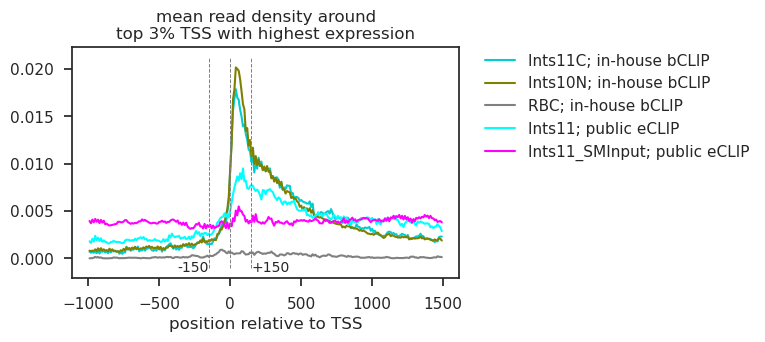

In [60]:
x_feature,y_feature = 'pos_rel_to_TSS','mean'
expr_cat = ''
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(5,3),)

i=0
for index,row in samples_to_analyze_df.iterrows():
    sample = row['sample']
    condition = row['condition']
    color = plot_specification.loc[plot_specification['condition']==condition].iloc[0]['color']
    
    file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/metaplot/'+sample+'.1.uniquely_mapped_0.metaplot_density.tsv'
    tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0)

    # take the highest category if not RBC
    if condition!='RBC; in-house bCLIP':
        l = list(tmp['expr_cat'].unique())
        l.sort()
        tmp = tmp.loc[tmp['expr_cat']==l[-1]].reset_index(drop=True)
    else:
        k = [32985,220,69,17,1]
        k[0]=int(sum(k)*0.03)-sum(k[1:])
        summa = sum(k)
        w = [elem/summa for elem in k]
        weights_df = pd.DataFrame([list(tmp['expr_cat'].unique()),w]).transpose()
        weights_df.columns = ['expr_cat','w']
        tmp = pd.merge(tmp,weights_df,how='left',on='expr_cat')
        tmp[y_feature] = tmp[y_feature]*tmp['w']
        tmp=tmp.groupby(x_feature).agg({y_feature:np.mean}).reset_index()
    ax = sns.lineplot(data = tmp,x=x_feature,y=y_feature,color=color,label=condition)
    
    i=i+1
ax.set(title='mean read density around\ntop 3% TSS with highest expression',ylabel='',xlabel='position relative to TSS')
ymin,ymax = ax.get_ylim()[0],ax.get_ylim()[1]
ax.vlines(x=0,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.vlines(x=150,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.vlines(x=-150,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.text(-150,-0.001,'-150',ha='right',va='center',size=10)
ax.text(150,-0.001,'+150',ha='left',va='center',size=10)

ax.tick_params(bottom=True,left=True)

ax.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.0,title='')

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'Reproducibility/', shell=True)
fig.savefig(subdirs['figures_dir']+'Reproducibility/Metaplots.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'Reproducibility/Metaplots.pdf',bbox_inches='tight',dpi=600)

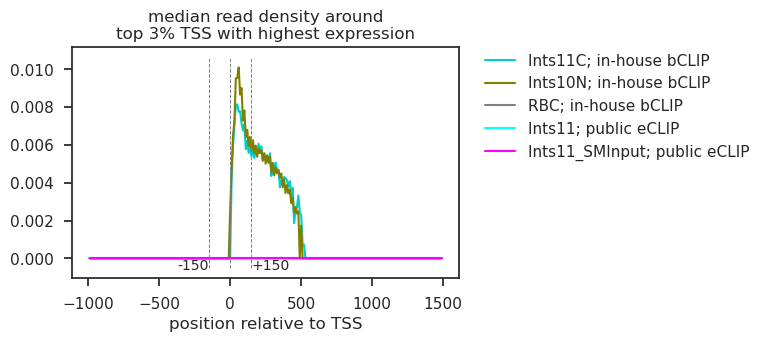

In [67]:
x_feature,y_feature = 'pos_rel_to_TSS','median'
expr_cat = ''
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(5,3),)

i=0
for index,row in samples_to_analyze_df.iterrows():
    sample = row['sample']
    condition = row['condition']
    color = plot_specification.loc[plot_specification['condition']==condition].iloc[0]['color']
    
    file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/metaplot/'+sample+'.1.uniquely_mapped_0.metaplot_density.tsv'
    tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0)

    # take the highest category if not RBC
    if condition!='RBC; in-house bCLIP':
        l = list(tmp['expr_cat'].unique())
        l.sort()
        tmp = tmp.loc[tmp['expr_cat']==l[-1]].reset_index(drop=True)
    else:
        k = [32985,220,69,17,1]
        k[0]=int(sum(k)*0.03)-sum(k[1:])
        summa = sum(k)
        w = [elem/summa for elem in k]
        weights_df = pd.DataFrame([list(tmp['expr_cat'].unique()),w]).transpose()
        weights_df.columns = ['expr_cat','w']
        tmp = pd.merge(tmp,weights_df,how='left',on='expr_cat')
        tmp[y_feature] = tmp[y_feature]*tmp['w']
        tmp=tmp.groupby(x_feature).agg({y_feature:np.mean}).reset_index()
    ax = sns.lineplot(data = tmp,x=x_feature,y=y_feature,color=color,label=condition)
    
    i=i+1
ax.set(title='median read density around\ntop 3% TSS with highest expression',ylabel='',xlabel='position relative to TSS')
ymin,ymax = ax.get_ylim()[0],ax.get_ylim()[1]
ax.vlines(x=0,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.vlines(x=150,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.vlines(x=-150,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.text(-150,-0.0004,'-150',ha='right',va='center',size=10)
ax.text(150,-0.0004,'+150',ha='left',va='center',size=10)

ax.tick_params(bottom=True,left=True)

ax.legend(bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.0,title='')

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'Reproducibility/', shell=True)
fig.savefig(subdirs['figures_dir']+'Reproducibility/Metaplots_median.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'Reproducibility/Metaplots_median.pdf',bbox_inches='tight',dpi=600)

## Make quantification for Ints11C, Ints10N, RBC, eCLIP (Hela)

In [4]:
experimental_bCLIP_samples = pd.read_csv(subdirs['metadata_dir']+'experimental_bCLIP_samples.tsv',delimiter="\t",index_col=None,header=0)
public_bCLIP_and_ChipSeq_samples = pd.read_csv(subdirs['metadata_dir']+'public_bCLIP_and_ChipSeq_samples.tsv',delimiter="\t",index_col=None,header=0)

experiments_to_analyze = ['RBC_exp17','RBC_exp18','Ints11C_replicate5','Ints11C_replicate6','Ints10N_replicate1','Ints10N_replicate2',
                          'SRR11551259','SRR11551260','SRR11551261','SRR11551262']

experimental_bCLIP_samples['type'] = 'in-house bCLIP'
public_bCLIP_and_ChipSeq_samples['type'] = 'public eCLIP'

samples_to_analyze_df = pd.concat([experimental_bCLIP_samples.loc[experimental_bCLIP_samples['name'].isin(experiments_to_analyze)][['name','type','condition_name','batch']],
                                  public_bCLIP_and_ChipSeq_samples.loc[(public_bCLIP_and_ChipSeq_samples['name'].isin(experiments_to_analyze))][['name','type','condition_name','batch']]]).reset_index(drop=True)
samples_to_analyze_df['condition'] = samples_to_analyze_df['condition_name']+'; '+samples_to_analyze_df['type']
samples_to_analyze_df['organism'] = samples_to_analyze_df.apply(lambda x:'human' if ('Hela' in x['batch']) else 'mouse',1)

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)
plot_specification['color'] = ['darkturquoise','olive','grey','cyan','magenta']

samples_to_analyze_df = samples_to_analyze_df[['name','condition','organism']].rename(columns = {'name':'sample'})

In [5]:
organisms = list(samples_to_analyze_df['organism'].unique())
cl = []
for organism in organisms:
    enriched_gtf = pd.read_csv(file_paths[organism+'_enriched_annotation_file'],delimiter="\t",
                                       index_col=None,header=None,usecols = [0])
    chromosome_list =  list(enriched_gtf[0].unique())
    cl.append([organism,' '.join(chromosome_list)])
cl = pd.DataFrame(cl,columns=['organism','chromosomes'])

In [6]:
counts = {}
for index1,row1 in cl.iterrows():
    organism = row1['organism']
    chromosomes = row1['chromosomes'].split(' ')
    a1 = []
    for chromosome in chromosomes:
        i=0
        a = []
        for index,row in samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism].iterrows():
            sample = row['sample']
            file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/sel_TSSs/'+sample+'.'+chromosome+'.wd_counts.tsv'
            if i==0:
                tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols = [0,3,4,5])
            else:
                tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols=[5])
            tmp = tmp.rename(columns = {'uniquely_mapped;0':sample})
            a.append(tmp)
            i=i+1
        a = pd.concat(a,axis=1)
        a1.append(a)
        print(organism+', '+chromosome+' done')
    a1 = pd.concat(a1).reset_index(drop=True)
    a1[['chr','strand']] = a1[['chr','strand']].astype('category')
    counts[organism] = a1

mouse, chr1 done
mouse, chr2 done
mouse, chr3 done
mouse, chr4 done
mouse, chr5 done
mouse, chr6 done
mouse, chr7 done
mouse, chr8 done
mouse, chr9 done
mouse, chr10 done
mouse, chr11 done
mouse, chr12 done
mouse, chr13 done
mouse, chr14 done
mouse, chr15 done
mouse, chr16 done
mouse, chr17 done
mouse, chr18 done
mouse, chr19 done
mouse, chrX done
mouse, chrY done
mouse, chrM done
human, chr1 done
human, chr2 done
human, chr3 done
human, chr4 done
human, chr5 done
human, chr6 done
human, chr7 done
human, chr8 done
human, chr9 done
human, chr10 done
human, chr11 done
human, chr12 done
human, chr13 done
human, chr14 done
human, chr15 done
human, chr16 done
human, chr17 done
human, chr18 done
human, chr19 done
human, chr20 done
human, chr21 done
human, chr22 done
human, chrX done
human, chrY done
human, chrM done


In [10]:
organism = 'human'
segments_of_interest = ['signal','control_up']
samples_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['sample'])

df = counts[organism]
df[samples_list] = df[samples_list].astype('int')
df['TSS'] = df.apply(lambda x:x['segment_name'].split(';')[-1]+';'+x['segment_name'].split(';')[1],1)
df['segment'] = df.apply(lambda x:x['segment_name'].split(';')[0],1).astype('category')
df = df.loc[df['segment'].isin(segments_of_interest)].reset_index(drop=True)

pivot = pd.pivot_table(df,index=['TSS','chr','strand'],columns='segment',values = samples_list).reset_index()
columns = []
for elem in pivot.columns:
    columns.append(';'.join(elem) if elem[1]!='' else elem[0])
pivot.columns = columns

a = []
for sample in samples_list:
    values = pivot[list(sample+';'+pd.Series(segments_of_interest))].drop_duplicates().reset_index(drop=True)
    values.columns = segments_of_interest
    a.append(values)
values = pd.concat(a).drop_duplicates().reset_index(drop=True)
values['sum'] = values[segments_of_interest].sum(1)
values['pval'] = values.apply(lambda x:stats.binomtest(k=x[segments_of_interest[0]],n=x['sum'],p=0.5,alternative='greater').pvalue if x['sum']>0 else 1,1)
values['lfc'] = np.log2((values[segments_of_interest[0]]+1)/(values[segments_of_interest[1]]+1))
values['average_log2'] = np.log2(values['sum']+1)
for sample in samples_list:
    pivot = pd.merge(pivot,values.drop('sum',1).rename(columns={segments_of_interest[0]:sample+';'+segments_of_interest[0],
                       segments_of_interest[1]:sample+';'+segments_of_interest[1],
                      'pval':sample+';pval','lfc':sample+';lfc','average_log2':sample+';average_log2'}),how='left',on=[sample+';'+segments_of_interest[0],sample+';'+segments_of_interest[1]])

In [11]:
len(pivot)

70139

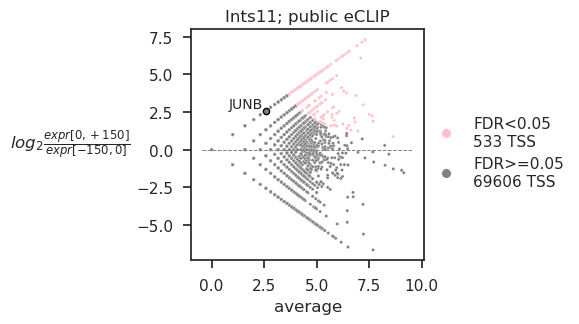

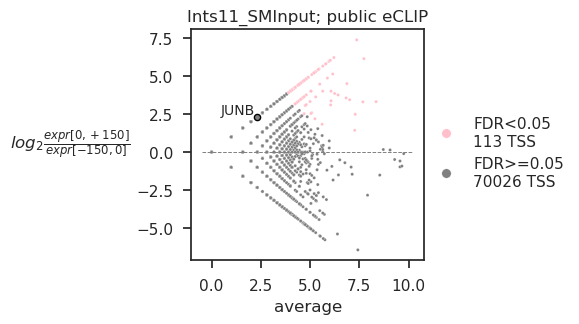

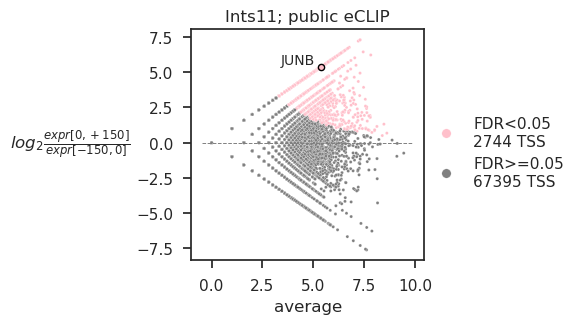

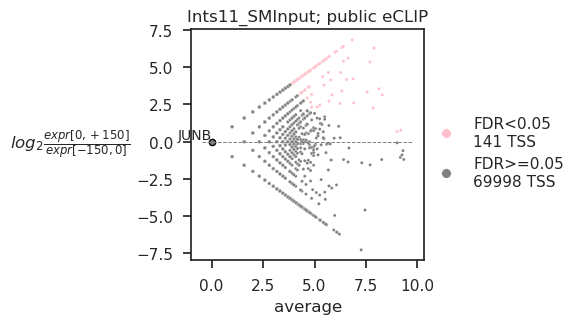

In [30]:
for sample_example in samples_list:
    thr_significance = 0.05
    title=samples_to_analyze_df.loc[samples_to_analyze_df['sample']==sample_example].iloc[0]['condition']
    TSSs_of_interest = {'Junb;85705347':'Junb','JUNB;12791486':'JUNB'}
    # TSSs_of_interest = {'Junb;85705347':'Junb','JUNB;12791486':'JUNB','Jun;94940459':'Jun','JUN;58784048':'JUN','Fos;85520664':'Fos','FOS;75278826':'FOS'}
    
    data = pivot[['TSS','chr','strand',sample_example+';average_log2',sample_example+';lfc',sample_example+';pval']]
    data = data.rename(columns = {sample_example+';average_log2':'average_log2',sample_example+';lfc':'lfc',sample_example+';pval':'pval'})
    data['FDR'] = multipletests(data['pval'],method = 'fdr_bh')[1]
    data['sign'] = (data['FDR']<thr_significance).astype('str').str.replace('True','FDR<'+str(thr_significance)).replace('False','FDR>='+str(thr_significance)).astype('category')
    
    data_to_show = data.loc[data['TSS'].isin(TSSs_of_interest)].reset_index(drop=True)
    
    x_feature,y_feature,hue = 'average_log2','lfc','sign'
    hue_order = ['FDR<'+str(thr_significance),'FDR>='+str(thr_significance)]
    palette = ['pink','grey']
    
    sns.set(font_scale=1)
    sns.set_style("white")
    fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3),)
    
    ax = sns.scatterplot(data = data,x=x_feature,y=y_feature,hue=hue,s=5,hue_order = hue_order,palette = palette,alpha=1)
    ax = sns.scatterplot(data = data_to_show,x=x_feature,y=y_feature,hue=hue,s=20,edgecolor='black',linewidth=1,hue_order = hue_order,palette = palette,
                         alpha=1,legend=None)
    
    for index, row in data_to_show.iterrows():
        ax.text(row[x_feature]*0.95,row[y_feature],TSSs_of_interest[row['TSS']],ha='right',va='bottom',size=10)
        
    ax.set(xlabel = 'average',title=title)
    ax.set_ylabel(ylabel=r'$log_2\frac{expr[0,+150]}{expr[-150,0]}$',rotation=0,ha='right',va='center',rotation_mode='anchor')
    ax.hlines(y=0,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1],color='grey',linestyles='--',linewidth=0.7)

    legend_labels = [elem+'\n'+str(len(data.loc[data[hue]==elem]))+' TSS' for elem in hue_order]
    h, l = ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(1.001, 0.65),loc=2,borderaxespad=0.0,title='',markerscale=3,handles = h,labels = legend_labels)
    
    ax.tick_params(bottom=True,left=True)
    
    out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'bCLIP_quantification/', shell=True)
    fig.savefig(subdirs['figures_dir']+'bCLIP_quantification/'+sample_example+'_MAplot.png',bbox_inches='tight',dpi=600)
    fig.savefig(subdirs['figures_dir']+'bCLIP_quantification/'+sample_example+'_MAplot.pdf',bbox_inches='tight',dpi=600)

In [15]:
res = {}
for organism in ['mouse','human']:
    segments_of_interest = ['signal','control_up']
    samples_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['sample'])
    
    df = counts[organism]
    df[samples_list] = df[samples_list].astype('int')
    df['TSS'] = df.apply(lambda x:x['segment_name'].split(';')[-1]+';'+x['segment_name'].split(';')[1],1)
    df['segment'] = df.apply(lambda x:x['segment_name'].split(';')[0],1).astype('category')
    df = df.loc[df['segment'].isin(segments_of_interest)].reset_index(drop=True)
    
    pivot = pd.pivot_table(df,index=['TSS','chr','strand'],columns='segment',values = samples_list).reset_index()
    columns = []
    for elem in pivot.columns:
        columns.append(';'.join(elem) if elem[1]!='' else elem[0])
    pivot.columns = columns
    
    a = []
    for sample in samples_list:
        values = pivot[list(sample+';'+pd.Series(segments_of_interest))].drop_duplicates().reset_index(drop=True)
        values.columns = segments_of_interest
        a.append(values)
    values = pd.concat(a).drop_duplicates().reset_index(drop=True)
    values['sum'] = values[segments_of_interest].sum(1)
    values['pval'] = values.apply(lambda x:stats.binomtest(k=x[segments_of_interest[0]],n=x['sum'],p=0.5,alternative='greater').pvalue if x['sum']>0 else 1,1)
    values['lfc'] = np.log2((values[segments_of_interest[0]]+1)/(values[segments_of_interest[1]]+1))
    values['average_log2'] = np.log2(values['sum']+1)
    for sample in samples_list:
        pivot = pd.merge(pivot,values.drop('sum',1).rename(columns={segments_of_interest[0]:sample+';'+segments_of_interest[0],
                           segments_of_interest[1]:sample+';'+segments_of_interest[1],
                          'pval':sample+';pval','lfc':sample+';lfc','average_log2':sample+';average_log2'}),how='left',on=[sample+';'+segments_of_interest[0],sample+';'+segments_of_interest[1]])
    
    thr_significance = 0.05
    for sample in samples_list:
        pivot[sample+';FDR'] = multipletests(pivot[sample+';pval'],method = 'fdr_bh')[1]
        pivot[sample+';sign'] = (pivot[sample+';FDR']<thr_significance).astype('int')
    pivot['gene_name'] = pivot.apply(lambda x:x['TSS'].split(';')[0].upper(),1)
    pivot['coordinate'] = pivot['TSS'].str.split(';',expand=True)[1].astype('int')
    res[organism] = pivot[['TSS','gene_name','coordinate','chr','strand']+list(pd.Series(samples_list)+';sign')]
    print(organism+' done')

mouse done
human done


In [16]:
data_bCLIP = res['mouse'].copy() # use downstream
out = subprocess.check_output('mkdir -p '+subdirs['tables_dir']+'bCLIP_quantification/', shell=True)
data_bCLIP.to_csv(subdirs['tables_dir']+'bCLIP_quantification/'+'bCLIP.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

In [191]:
data_eCLIP = res['human'].copy() # use downstream
for index,row in samples_to_analyze_df.iterrows():
    if row['organism'] == 'human':
        data_eCLIP = data_eCLIP.rename(columns={row['sample']+';sign':row['sample']+';'+row['condition']+';sign'})
out = subprocess.check_output('mkdir -p '+subdirs['tables_dir']+'bCLIP_quantification/', shell=True)
data_eCLIP.to_csv(subdirs['tables_dir']+'bCLIP_quantification/'+'eCLIP.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

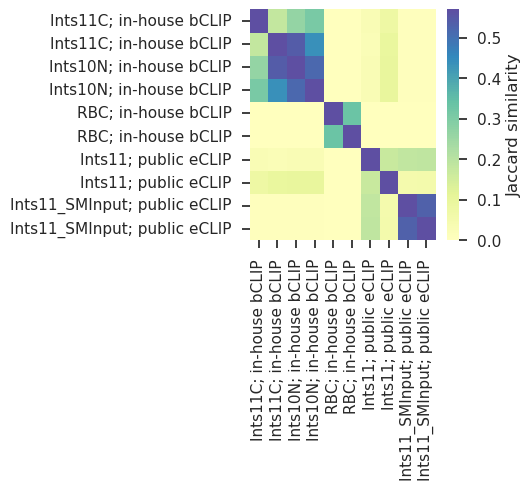

In [192]:
### look at proximal TSS only
proximal_TSSs = {}
for organism in ['mouse','human']:
    df = res[organism][['gene_name','coordinate','strand']]
    gr_plus = df.loc[df['strand']=='+'].groupby('gene_name').agg({'coordinate':np.min}).reset_index()
    gr_minus = df.loc[df['strand']=='-'].groupby('gene_name').agg({'coordinate':np.max}).reset_index()
    gr = pd.concat([gr_plus,gr_minus]).reset_index(drop=True)
    proximal_TSS = pd.merge(res[organism].drop(['TSS','chr','strand'],1),gr,how='inner',on=['gene_name','coordinate']).drop(['coordinate'],1)
    proximal_TSSs[organism] = proximal_TSS
common_TSS = pd.merge(proximal_TSSs['human'],proximal_TSSs['mouse'],how='inner',on='gene_name')

cols = list(common_TSS.columns[1:])
cols = pd.DataFrame(cols)
cols['sample'] = cols[0].str.split(';',expand=True)[0]
common_TSS.columns = ['gene_name']+list(cols['sample'])

cols = pd.merge(cols,samples_to_analyze_df,how='right',on='sample')
cols = pd.merge(cols,plot_specification,how='right',on='condition')

common_TSS = common_TSS[['gene_name']+list(cols['sample'])]

from sklearn.metrics.pairwise import pairwise_distances
A = 1 - pairwise_distances(common_TSS[list(cols['sample'])].T.to_numpy(), metric='jaccard')
A = pd.DataFrame(A,columns = cols['condition'])
A.index = cols['condition']

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3))

ax = sns.heatmap(A,cbar_kws={'label': 'Jaccard similarity'},vmin=0,vmax=0.57,center=0,cmap=sns.color_palette('Spectral',as_cmap=True))
ax.set(xlabel="", ylabel="")

ax.tick_params(bottom=True,left=True)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'bCLIP_quantification/', shell=True)
fig.savefig(subdirs['figures_dir']+'bCLIP_quantification/'+'HeatMap.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'bCLIP_quantification/'+'HeatMap.pdf',bbox_inches='tight',dpi=600)

In [195]:
common_TSS_exp = common_TSS.copy()
for index,row in samples_to_analyze_df.iterrows():
    common_TSS_exp = common_TSS_exp.rename(columns={row['sample']:row['sample']+';'+row['condition']+';sign'})
common_TSS_exp.to_csv(subdirs['tables_dir']+'bCLIP_quantification/'+'common_proximal_TSS.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

# Compare bCLIP with PRO-seq

## Metaplot for PRO-seq

In [127]:
public_PROseq_samples = pd.read_csv(subdirs['metadata_dir']+'public_PROseq_samples.tsv',delimiter="\t",index_col=None,header=0)
samples_to_analyze_df = public_PROseq_samples[['name','condition_name']]
samples_to_analyze_df = samples_to_analyze_df.rename(columns={'name':'sample','condition_name':'condition'})

experiments_to_analyze = ['SRR18735674','SRR18735676']
samples_to_analyze_df = samples_to_analyze_df.loc[samples_to_analyze_df['sample'].isin(experiments_to_analyze)].reset_index(drop=True)

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)
plot_specification['color'] = ['orange','grey']

In [128]:
8154/(3470+438+493+511+8154)

0.6240624521659268

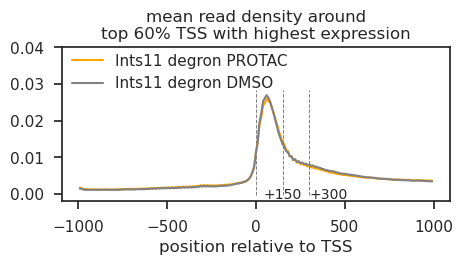

In [135]:
x_feature,y_feature = 'pos_rel_to_TSS','mean'
expr_cat = ''
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(5,2),)

i=0
title_dict = {'INTS11_degron':'Ints11 degron PROTAC','DMSO':'Ints11 degron DMSO'}
for index,row in samples_to_analyze_df.iterrows():
    sample = row['sample']
    condition = row['condition']
    title = title_dict[condition]
    color = plot_specification.loc[plot_specification['condition']==condition].iloc[0]['color']
    
    file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/metaplot/'+sample+'.1.uniquely_mapped_0.metaplot_density.tsv'
    tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0)

    l = list(tmp['expr_cat'].unique())
    l.sort()
    tmp = tmp.loc[tmp['expr_cat']==l[-1]].reset_index(drop=True)
    ax = sns.lineplot(data = tmp,x=x_feature,y=y_feature,color=color,label=title)
    
    i=i+1
ax.set(title='mean read density around\ntop 60% TSS with highest expression',ylabel='',xlabel='position relative to TSS')
ymin,ymax = ax.get_ylim()[0],ax.get_ylim()[1]
ax.vlines(x=0,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.vlines(x=300,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.vlines(x=150,ymin=ymin,ymax=ymax,color='grey',linestyles='--',linewidth=0.7)
ax.text(150,-0.0001,'+150',ha='center',va='center',size=10)
ax.text(300,-0.0001,'+300',ha='left',va='center',size=10)
ax.set(ylim=(-0.002,0.04))
ax.legend(bbox_to_anchor=(0.01, 1),loc=2,borderaxespad=0.0,title='')

ax.tick_params(bottom=True,left=True)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'PROseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'PROseq/Metaplots.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'PROseq/Metaplots.pdf',bbox_inches='tight',dpi=600)

## Quantification for PRO-seq

In [32]:
public_PROseq_samples = pd.read_csv(subdirs['metadata_dir']+'public_PROseq_samples.tsv',delimiter="\t",index_col=None,header=0)
samples_to_analyze_df = public_PROseq_samples[['name','condition_name']]
samples_to_analyze_df = samples_to_analyze_df.rename(columns={'name':'sample','condition_name':'condition'})
samples_to_analyze_df['organism'] = 'mouse'

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)
plot_specification['color'] = ['orange','grey']

In [33]:
organisms = list(samples_to_analyze_df['organism'].unique())
cl = []
for organism in organisms:
    enriched_gtf = pd.read_csv(file_paths[organism+'_enriched_annotation_file'],delimiter="\t",
                                       index_col=None,header=None,usecols = [0])
    chromosome_list =  list(enriched_gtf[0].unique())
    cl.append([organism,' '.join(chromosome_list)])
cl = pd.DataFrame(cl,columns=['organism','chromosomes'])

In [34]:
counts = {}
for index1,row1 in cl.iterrows():
    organism = row1['organism']
    chromosomes = row1['chromosomes'].split(' ')
    a1 = []
    for chromosome in chromosomes:
        i=0
        a = []
        for index,row in samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism].iterrows():
            sample = row['sample']
            file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/sel_TSSs/'+sample+'.'+chromosome+'.wd_counts.tsv'
            if i==0:
                tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols = [0,3,4,5])
            else:
                tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols=[5])
            tmp = tmp.rename(columns = {'uniquely_mapped;0':sample})
            a.append(tmp)
            i=i+1
        a = pd.concat(a,axis=1)
        a1.append(a)
        print(organism+', '+chromosome+' done')
    a1 = pd.concat(a1).reset_index(drop=True)
    a1[['chr','strand']] = a1[['chr','strand']].astype('category')
    counts[organism] = a1

mouse, chr1 done
mouse, chr2 done
mouse, chr3 done
mouse, chr4 done
mouse, chr5 done
mouse, chr6 done
mouse, chr7 done
mouse, chr8 done
mouse, chr9 done
mouse, chr10 done
mouse, chr11 done
mouse, chr12 done
mouse, chr13 done
mouse, chr14 done
mouse, chr15 done
mouse, chr16 done
mouse, chr17 done
mouse, chr18 done
mouse, chr19 done
mouse, chrX done
mouse, chrY done
mouse, chrM done


In [36]:
organism = 'mouse'
segments_of_interest = ['signal','control_down']
samples_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['sample'])
condition_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['condition'])

df = counts[organism]
df[samples_list] = df[samples_list].astype('int')

df['TSS'] = df.apply(lambda x:x['segment_name'].split(';')[-1]+';'+x['segment_name'].split(';')[1],1)
df['segment'] = df.apply(lambda x:x['segment_name'].split(';')[0],1).astype('category')
df = df.loc[df['segment'].isin(segments_of_interest)].reset_index(drop=True)

pivot = pd.pivot_table(df,index=['TSS','chr','strand'],columns='segment',values = samples_list).reset_index()
columns = []
for elem in pivot.columns:
    columns.append(';'.join(elem) if elem[1]!='' else elem[0])
pivot.columns = columns

cols_for_fisher = []
for condition in list(samples_to_analyze_df['condition'].unique()):
    s = pd.Series(samples_to_analyze_df.loc[samples_to_analyze_df['condition']==condition]['sample'])
    for segment in segments_of_interest:
        pivot[condition+';'+segment] = pivot[list(s+';'+segment)].sum(1)
        cols_for_fisher.append(condition+';'+segment)
        
values = pivot[cols_for_fisher].drop_duplicates().reset_index(drop=True)
values['average_log2'] = np.log2(values[cols_for_fisher].mean(1))
values[list(plot_specification['condition'])[0]+';ratio'] = (values[list(plot_specification['condition'])[0]+';'+segments_of_interest[1]]+1)/(values[list(plot_specification['condition'])[0]+';'+segments_of_interest[0]]+1)
values[list(plot_specification['condition'])[1]+';ratio'] = (values[list(plot_specification['condition'])[1]+';'+segments_of_interest[1]]+1)/(values[list(plot_specification['condition'])[1]+';'+segments_of_interest[0]]+1)
values['log2_OR'] = np.log2(values[list(plot_specification['condition'])[0]+';ratio']/values[list(plot_specification['condition'])[1]+';ratio'])
values['pval'] = values.apply(lambda x:stats.fisher_exact([[x[list(plot_specification['condition'])[0]+';'+segments_of_interest[1]],x[list(plot_specification['condition'])[0]+';'+segments_of_interest[0]]],
                                                           [x[list(plot_specification['condition'])[1]+';'+segments_of_interest[1]],x[list(plot_specification['condition'])[1]+';'+segments_of_interest[0]]]],
                                                         alternative='two-sided')[1],1)
pivot = pd.merge(pivot,values,how='left',on=cols_for_fisher)
pivot['FDR'] = multipletests(pivot['pval'],method = 'fdr_bh')[1]

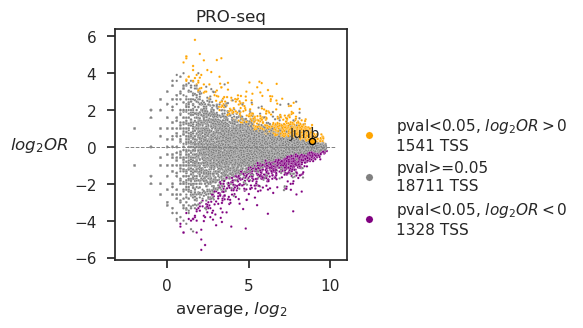

In [40]:
thr_significance = 0.05
# TSSs_of_interest = {'Junb;85705347':'Junb','Fos;85520664':'Fos','FOS;75278826':'FOS','JUNB;12791486':'JUNB'}
TSSs_of_interest = {'Junb;85705347':'Junb','JUNB;12791486':'JUNB'}

data = pivot[['TSS','chr','strand','average_log2','log2_OR','pval','FDR']]
data['sign'] = (data['pval']<thr_significance).astype('int')
map_dict = {-1:'pval<'+str(thr_significance)+', $log_2OR<0$',1:'pval<'+str(thr_significance)+', $log_2OR>0$',0:'pval>='+str(thr_significance)}
data['PROseq_cat'] = (data['sign']*((data['log2_OR']>0).astype('int')*2-1)).map(map_dict)

data_to_show = data.loc[data['TSS'].isin(TSSs_of_interest)].reset_index(drop=True)

x_feature,y_feature,hue = 'average_log2','log2_OR','PROseq_cat'
hue_order = ['pval<'+str(thr_significance)+', $log_2OR>0$','pval>='+str(thr_significance),'pval<'+str(thr_significance)+', $log_2OR<0$']
palette = ['orange','grey','purple']

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3),)

ax = sns.scatterplot(data = data,x=x_feature,y=y_feature,hue=hue,s=3,hue_order = hue_order,palette = palette,alpha=1)
ax = sns.scatterplot(data = data_to_show,x=x_feature,y=y_feature,hue=hue,s=20,edgecolor='black',linewidth=1,hue_order = hue_order,palette = palette,
                     alpha=1,legend=None)

for index, row in data_to_show.iterrows():
    ax.text(row[x_feature]*0.95,row[y_feature]*1.2,TSSs_of_interest[row['TSS']],ha='center',va='bottom',size=10)
    
ax.set(xlabel = 'average, $log_2$',title='PRO-seq')
ax.set_ylabel(ylabel=r'$log_2OR$',rotation=0,ha='right',va='center',rotation_mode='anchor')
ax.hlines(y=0,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1],color='grey',linestyles='--',linewidth=0.7)

legend_labels = [elem+'\n'+str(len(data.loc[data[hue]==elem]))+' TSS' for elem in hue_order]
h, l = ax.get_legend_handles_labels()

ax.legend(bbox_to_anchor=(1.001, 0.65),loc=2,borderaxespad=0.0,title='',markerscale=3,handles = h,labels = legend_labels)

ax.tick_params(bottom=True,left=True)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'PROseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'PROseq/MA_plot.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'PROseq/MA_plot.pdf',bbox_inches='tight',dpi=600)

In [22]:
data_PROseq = data.copy()
out = subprocess.check_output('mkdir -p '+subdirs['tables_dir']+'PROseq_quantification/', shell=True)
data_PROseq.to_csv(subdirs['tables_dir']+'PROseq_quantification/'+'PROseq.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

In [86]:
### Compare with bCLIP

In [ ]:
data_bCLIP = pd.read_csv(subdirs['tables_dir']+'bCLIP_quantification/'+'bCLIP.tsv',delimiter="\t",index_col=None,header=0)

In [23]:
data_intersect = pd.merge(data_PROseq,data_bCLIP,how='inner',on=['TSS','chr','strand'])

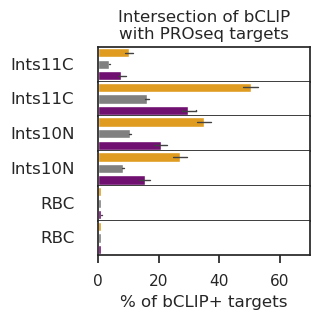

In [292]:
order = ['pval<'+str(thr_significance)+', $log_2OR>0$','pval>='+str(thr_significance),'pval<'+str(thr_significance)+', $log_2OR<0$']
palette = ['orange','grey','purple']

bclip_samples = ['Ints11C_replicate5','Ints11C_replicate6','Ints10N_replicate1','Ints10N_replicate2','RBC_exp17','RBC_exp18']

def func1(x):
    return 100*np.mean(x)+1

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(len(bclip_samples),1,sharey=True,sharex=True, figsize=(3,3))
j=0
for sample in bclip_samples:
    ax = sns.barplot(ax=axes[j],data = data_intersect, orient='h',y="PROseq_cat", x=sample+";sign", 
                     estimator=func1,palette = palette,order=order,capsize=0.001,errwidth=1)
    ax.set_ylabel(ylabel=sample.split('_')[0],rotation=0,ha='right',va='center',rotation_mode='anchor')
    ax.set(yticklabels=[],xlabel='',xlim=(0,70))
    if j==0:
        ax.set(title='Intersection of bCLIP\nwith PROseq targets')
    if j>0:
        for spline in ['top']:
            ax.spines[spline].set_visible(False)
    j=j+1
ax.tick_params(bottom=True)
ax.set(xlabel = '% of bCLIP+ targets')
fig.tight_layout(pad=0.001)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'PROseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'PROseq/Enrichment_bCLIP_ProSeq.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'PROseq/Enrichment_bCLIP_ProSeq.pdf',bbox_inches='tight',dpi=600)

In [55]:
data_intersect['11C+\nAND\n10N+'] = (data_intersect['Ints11C_replicate6;sign']+data_intersect['Ints10N_replicate1;sign']==2).astype('int')
data_intersect['11C+\nOR\n10N+'] = (data_intersect['Ints11C_replicate6;sign']+data_intersect['Ints10N_replicate1;sign']>0).astype('int')
data_intersect['11C+\nAND\n10N-'] = ((data_intersect['Ints11C_replicate6;sign']==1)&(data_intersect['Ints10N_replicate1;sign']==0)).astype('int')
data_intersect['11C-\nAND\n10N+'] = ((data_intersect['Ints11C_replicate6;sign']==0)&(data_intersect['Ints10N_replicate1;sign']==1)).astype('int')

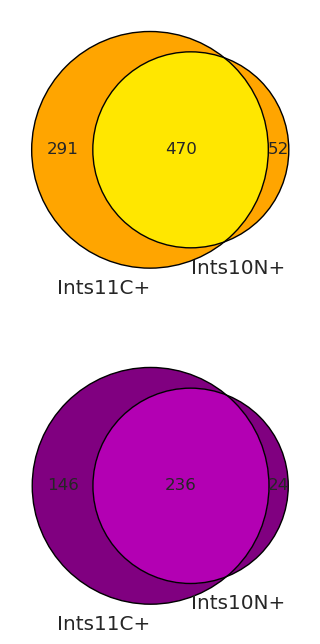

In [293]:
from matplotlib_venn import venn3,venn3_circles
from matplotlib_venn import venn2,venn2_circles

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(2, 1, sharey=False, sharex=False, figsize=(4,8))

labels_of_interest = ['Ints11C_replicate6;sign','Ints10N_replicate1;sign']
labels_to_show = ['Ints11C+','Ints10N+']
i=0
palette = ['orange','purple']
for category in ['pval<'+str(thr_significance)+', $log_2OR>0$','pval<'+str(thr_significance)+', $log_2OR<0$']:
    ax = sns.scatterplot(ax=axes[i],data = None)
    ax.set(xlabel=category)

    data = data_intersect.loc[data_intersect['PROseq_cat']==category].reset_index(drop=True)
    
    TSS_lists = []
    for label in labels_of_interest:
        TSS_list = set(list(data.loc[data[label]==1]['TSS'].astype('str')))
        TSS_lists.append(TSS_list)
    
    v = venn2(TSS_lists,set_labels=labels_to_show,set_colors=[palette[i]]*3,ax=ax,alpha=1)
    c = venn2_circles(TSS_lists,color='black',linewidth=1,ax=ax)
    i=i+1

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'PROseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'PROseq/Vienn_Diagram.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'PROseq/Vienn_Diagram.pdf',bbox_inches='tight',dpi=600)

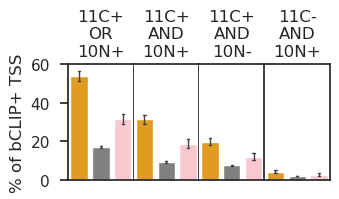

In [90]:
features = ['11C+\nOR\n10N+','11C+\nAND\n10N+','11C+\nAND\n10N-','11C-\nAND\n10N+']

def func1(x):
    return 100*np.mean(x)+1

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1,len(features),sharey=True,sharex=False, figsize=(0.8*len(features),1.8))

j=0
for feature in features:
    ax = sns.barplot(ax=axes[j],data = data_intersect, x="PROseq_cat", y=feature, estimator=func1,palette = palette,order=order,capsize=0.1,errwidth=1)
    ax.set(xticks=[],title=feature,xlabel='',ylabel='',ylim=(0,60))
    if j==0:
        ax.set(ylabel='% of bCLIP+ TSS')
        ax.tick_params(bottom=True,left=True)
    if j>0:
        for spline in ['left']:
            ax.spines[spline].set_visible(False)
    j=j+1
fig.tight_layout(pad=0.001)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'PROseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'PROseq/Enrichment_bCLIP_ProSeq_union_intersection.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'PROseq/Enrichment_bCLIP_ProSeq_union_intersection.pdf',bbox_inches='tight',dpi=600)

# Quantification for in-house and public RNA-seq

## get genic regions for FeatureCounts

In [ ]:
for organism in ['human','mouse']:
    enriched_gtf = pd.read_csv(file_paths[organism+'_annotation_file'],delimiter="\t",index_col=None,header=None,skiprows=5)

    ##########
    # for DE analysis, quantify genes from exonic parts shared by all transcripts of the gene
    ##########
    
    exons = enriched_gtf.loc[enriched_gtf[2]=='exon'].reset_index(drop=True)
    exons['transcript_id'] = exons[8].str.split('transcript_id "',expand=True)[1].str.split('";',expand=True)[0]
    exons['gene_id'] = exons[8].str.split('gene_id "',expand=True)[1].str.split('";',expand=True)[0]
    exons['gene_name'] = exons[8].str.split('gene_name "',expand=True)[1].str.split('";',expand=True)[0]
    exons['exon_number'] = exons[8].str.split('exon_number ',expand=True)[1].str.split(';',expand=True)[0].str.replace('"','').astype('int')
    exons['t']=1
    exons = pd.merge(exons.drop('t',1),exons.groupby('transcript_id').agg({'t':sum}).reset_index(),how='inner',on='transcript_id')
    
    ####
    # transform exons to bed format
    ####
    exons_bed = exons[[0,3,4,6,'transcript_id']].copy()
    new_transcript_ids = exons_bed[['transcript_id']].drop_duplicates().reset_index(drop=True) # transform transcript ids to integers to save space
    new_transcript_ids['new_transcript_id'] = new_transcript_ids.index
    exons_bed = pd.merge(exons_bed,new_transcript_ids,how='left',on='transcript_id')
    
    exons_bed['name'] = exons_bed['new_transcript_id']
    exons_bed['score'] = 0
    exons_bed[3]=exons_bed[3]-1
    exons_bed[[0,3,4,'name','score',6]].drop_duplicates().reset_index(drop=True).to_csv(subdirs['temp_dir']+'exons.bed', sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
    
    command = 'bedtools sort -i '+subdirs['temp_dir']+'exons.bed'+' > '+subdirs['temp_dir']+'exons.sorted.bed'
    out = subprocess.check_output(command, shell=True)
    
    ####
    # get all unique exonic segments
    ####
    exons['start_True'] = True
    exons['start_False'] = False
    
    a1 = []
    a1 = a1 + [exons[[0,3,6,'start_True']].drop_duplicates().rename(columns={3:1,6:2,'start_True':3}),
                        exons[[0,4,6,'start_False']].drop_duplicates().rename(columns={4:1,6:2,'start_False':3})]
    
    points = pd.concat(a1).sort_values([2,0,1,3]).drop_duplicates([0,1,2]).reset_index(drop=True) # prioritize element ends over starts if the coordinate matches exactly
    
    b = []
    prev_chr,prev_coord,prev_str='',-1,''
    for row in points.values:
        if (row[0]==prev_chr and row[2]==prev_str):
            b.append([row[0],prev_coord,(row[1]-1 if row[3] else row[1]),'n',0,row[2]])
        prev_chr,prev_coord,prev_str = row[0],(row[1] if row[3] else row[1]+1),row[2]
    segments = pd.DataFrame(b)
    segments[1] = segments[1]-1
    segments.to_csv(subdirs['temp_dir']+'exon_segments.bed', sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
    command = 'bedtools sort -i '+subdirs['temp_dir']+'exon_segments.bed'+' > '+subdirs['temp_dir']+'exon_segments.sorted.bed'
    out = subprocess.check_output(command, shell=True)
    
    ###
    # intersect exonic regions with exons to see which regions are overlapped by which exons
    ###
    
    command = 'bedtools intersect -wa -wb -s -a '+subdirs['temp_dir']+'exon_segments.sorted.bed'+' -b '+subdirs['temp_dir']+'exons.sorted.bed | bedtools groupby -g 1,2,3,6 -c 10 -o distinct > '+subdirs['temp_dir']+'exon_segments.intersected_annotation.tsv'
    out = subprocess.check_output(command, shell=True)
    
    exon_segments_intersected_annotation = pd.read_csv(subdirs['temp_dir']+'exon_segments.intersected_annotation.tsv',delimiter="\t",index_col=None,header=None)
    
    ###
    # transform the comma-separated modifed transcript ids back to transcript ids and rename those with gene_ids in mind
    ###
    
    unique_regions = list(exon_segments_intersected_annotation[4].unique())
    num = len(unique_regions)

    l = []
    i=0
    for elem in unique_regions:
        l = l + [[elem,elem1] for elem1 in elem.split(',')]
        if i%5000==0:
            print(str(i)+' out of '+str(num)+' done')
        i=i+1

    l_df = pd.DataFrame(l,columns=[4,'new_transcript_id'])
    l_df['new_transcript_id'] = l_df['new_transcript_id'].astype('int')
    l_df = pd.merge(l_df,new_transcript_ids,how='left',on='new_transcript_id')
    l_df = pd.merge(l_df,exons[['transcript_id','gene_id','gene_name']].drop_duplicates(),how='left',on='transcript_id')
    l_df['t']=1
    l_df.drop('t',axis=1).to_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.explanation_of_gene_ids.tsv', sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE) # save the explanation if there will be a need to do 

    l_df = pd.read_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.explanation_of_gene_ids.tsv',delimiter="\t",index_col=None,header=0)
    l_df = l_df.rename(columns={'4':4})
    l_df['t']=1
    l_df_dedup = l_df.groupby([4,'gene_id','gene_name']).agg({'t':sum}).reset_index()
    l_df_dedup['gene_ids'] = l_df_dedup[[4,'t','gene_id']].groupby([4,'t'])['gene_id'].transform(lambda x: ','.join(x))
    l_df_dedup['gene_names'] = l_df_dedup[[4,'t','gene_name']].groupby([4,'t'])['gene_name'].transform(lambda x: ','.join(x))
    l_df_dedup = l_df_dedup[[4,'t','gene_ids','gene_names']].drop_duplicates().reset_index(drop=True)
    l_df_dedup = pd.merge(l_df_dedup,l_df_dedup.groupby('gene_ids').agg({'t':max}).rename(columns={'t':'t_max'}),how='left',on='gene_ids')

    exon_segments_intersected_annotation = pd.merge(exon_segments_intersected_annotation,l_df_dedup,how='left',on=[4])
    exon_segments_intersected_annotation['new_gene_id'] = exon_segments_intersected_annotation['gene_ids']+':'+exon_segments_intersected_annotation[4].astype('str')+':'+exon_segments_intersected_annotation['t'].astype('str')+':'+exon_segments_intersected_annotation['t_max'].astype('str')
    exon_segments_intersected_annotation['new_gene_name'] = exon_segments_intersected_annotation['gene_names']+':'+exon_segments_intersected_annotation[4].astype('str')+':'+exon_segments_intersected_annotation['t'].astype('str')+':'+exon_segments_intersected_annotation['t_max'].astype('str')

    # make gtf out of bed format
    exon_segments_intersected_annotation_gtf = exon_segments_intersected_annotation.copy()
    
    a = []
    for strand in ['+','-']:
        if strand == '+':
            tmp = exon_segments_intersected_annotation_gtf.loc[exon_segments_intersected_annotation_gtf[3]==strand].sort_values(['new_gene_id',1,2]).reset_index(drop=True)
        else:
            tmp = exon_segments_intersected_annotation_gtf.loc[exon_segments_intersected_annotation_gtf[3]==strand].sort_values(['new_gene_id',1,2],ascending=[True,False,False]).reset_index(drop=True)
        tmp['e']=1
        tmp['exon_number'] = tmp[['new_gene_id','e']].groupby(['new_gene_id']).cumsum()
        a.append(tmp)
    exon_segments_intersected_annotation_gtf = pd.concat(a).reset_index(drop=True)
    
    exon_segments_intersected_annotation_gtf[1] = exon_segments_intersected_annotation_gtf[1]+1
    exon_segments_intersected_annotation_gtf = exon_segments_intersected_annotation_gtf.drop([4],axis=1).rename(columns={1:3,2:4,3:6})
    exon_segments_intersected_annotation_gtf[1] = 'CUSTOM'
    exon_segments_intersected_annotation_gtf[5] = '.'
    exon_segments_intersected_annotation_gtf[7] = '.'
    exon_segments_intersected_annotation_gtf[2] = 'exon'
    exon_segments_intersected_annotation_gtf[8] = 'gene_id "'+exon_segments_intersected_annotation_gtf['new_gene_id']+'"; transcript_id "'+exon_segments_intersected_annotation_gtf['new_gene_id']+':tr";'+\
    ' gene_type "NA"; gene_name "'+exon_segments_intersected_annotation_gtf['new_gene_name']+'"; transcript_type "NA"; transcript_name "'+exon_segments_intersected_annotation_gtf['new_gene_name']+':tr"; '+\
    'exon_number '+exon_segments_intersected_annotation_gtf['exon_number'].astype('str')+'; exon_id "'+exon_segments_intersected_annotation_gtf['new_gene_id']+':exon_'+exon_segments_intersected_annotation_gtf['exon_number'].astype('str')+'"'
    exon_segments_intersected_annotation_gtf['order'] = 3
    exon_segments_intersected_annotation_gtf_exons = exon_segments_intersected_annotation_gtf[list(range(0,9))+['new_gene_id','order']].copy()
    
    exon_segments_intersected_annotation_gtf_transcripts = exon_segments_intersected_annotation_gtf.groupby([0,1,2,5,6,7,'new_gene_id','new_gene_name']).agg({3:min,4:max}).reset_index()
    exon_segments_intersected_annotation_gtf_transcripts[2] = 'transcript'
    exon_segments_intersected_annotation_gtf_transcripts[8] = 'gene_id "'+exon_segments_intersected_annotation_gtf_transcripts['new_gene_id']+'"; transcript_id "'+exon_segments_intersected_annotation_gtf_transcripts['new_gene_id']+':tr";'+\
    ' gene_type "NA"; gene_name "'+exon_segments_intersected_annotation_gtf_transcripts['new_gene_name']+'"; transcript_type "NA"; transcript_name "'+exon_segments_intersected_annotation_gtf_transcripts['new_gene_name']+':tr"'
    exon_segments_intersected_annotation_gtf_transcripts['order'] = 2
    exon_segments_intersected_annotation_gtf_transcripts = exon_segments_intersected_annotation_gtf_transcripts[list(range(0,9))+['new_gene_id','order']]
    
    exon_segments_intersected_annotation_gtf_genes = exon_segments_intersected_annotation_gtf.groupby([0,1,2,5,6,7,'new_gene_id','new_gene_name']).agg({3:min,4:max}).reset_index()
    exon_segments_intersected_annotation_gtf_genes[2] = 'gene'
    exon_segments_intersected_annotation_gtf_genes[8] = 'gene_id "'+exon_segments_intersected_annotation_gtf_genes['new_gene_id']+'"; gene_type "NA"; gene_name "'+exon_segments_intersected_annotation_gtf_genes['new_gene_name']+'"'
    exon_segments_intersected_annotation_gtf_genes['order'] = 1
    exon_segments_intersected_annotation_gtf_genes = exon_segments_intersected_annotation_gtf_genes[list(range(0,9))+['new_gene_id','order']]
    
    exon_segments_intersected_annotation_gtf = pd.concat([exon_segments_intersected_annotation_gtf_genes,exon_segments_intersected_annotation_gtf_transcripts,exon_segments_intersected_annotation_gtf_exons]).sort_values(['new_gene_id','order']).drop(['new_gene_id','order'],axis=1)
    exon_segments_intersected_annotation_gtf = exon_segments_intersected_annotation_gtf.loc[exon_segments_intersected_annotation_gtf[3]<exon_segments_intersected_annotation_gtf[4]].reset_index(drop=True) # remove zero-length fragments
    
    exon_segments_intersected_annotation_gtf.to_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.gtf', sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

    # make short gene ids for Feature Counts
    exon_segments_intersected_annotation_gtf['gene_id'] = exon_segments_intersected_annotation_gtf[8].str.split('gene_id "',expand=True)[1].str.split('";',expand=True)[0]
    tmp = exon_segments_intersected_annotation_gtf[['gene_id']].drop_duplicates().reset_index(drop=True)
    tmp['short_gene_id'] = "g"+(tmp.index).astype('str')
    if 'short_gene_id' in list(exon_segments_intersected_annotation_gtf.columns):
        exon_segments_intersected_annotation_gtf = exon_segments_intersected_annotation_gtf.drop('short_gene_id',1)
    exon_segments_intersected_annotation_gtf = pd.merge(exon_segments_intersected_annotation_gtf,tmp,how='left',on='gene_id')
    exon_segments_intersected_annotation_gtf['8_new'] = exon_segments_intersected_annotation_gtf.apply(lambda x:x[8].replace(x['gene_id'],x['short_gene_id']),1)
    
    # save the explanation
    exon_segments_intersected_annotation_gtf[[8,'8_new']].drop_duplicates().reset_index(drop=True).to_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.explanation_of_short_gene_ids_feature_counts_.tsv', sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE) 
    
    exon_segments_intersected_annotation_gtf[8] = exon_segments_intersected_annotation_gtf['8_new']
    exon_segments_intersected_annotation_gtf = exon_segments_intersected_annotation_gtf.drop(['8_new','gene_id','short_gene_id'],1)
    
    exon_segments_intersected_annotation_gtf.to_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.gtf', sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

## Run FeatureCounts

In [31]:
exper_RNAseq_fastq_file_paths = pd.read_csv(subdirs['temp_dir']+"""exper_RNAseq_fastq_file_paths.tsv""",delimiter="\t",index_col=None,header=None)
exper_RNAseq_fastq_file_paths.columns = ['path']
exper_RNAseq_fastq_file_paths['name'] = exper_RNAseq_fastq_file_paths.apply(lambda x:x['path'].split('/')[-1][:-8],1)
experimental_samples = exper_RNAseq_fastq_file_paths.drop_duplicates('name').reset_index(drop=True)
experimental_samples['replicate'] = experimental_samples.apply(lambda x:x['name'].split('_')[0],1)

mouse_replicates = ['A12','A13','A14','A15','A18','A19']
human_replicates = list('A'+pd.Series(range(1,10)).astype('str'))

experimental_samples = experimental_samples.loc[experimental_samples['replicate'].isin(human_replicates+mouse_replicates)].reset_index(drop=True).drop('path',1)

condition_map = {'A12':'si_CTRL','A13':'si_Ints11','A14':'si_CTRL','A15':'si_Ints11','A18':'si_CTRL','A19':'si_Ints11',
                'A1':'si_CTRL','A2':'si_INTS6','A3':'si_INTS6L','A4':'si_CTRL','A5':'si_INTS6','A6':'si_INTS6L','A7':'si_CTRL','A8':'si_INTS6','A9':'si_INTS6L'}

experimental_samples['condition'] = experimental_samples['replicate'].map(condition_map)
samples_to_analyze_df = experimental_samples[['name','condition','replicate']]
samples_to_analyze_df['batch'] = 'in-house'
samples_to_analyze_df['organism'] = samples_to_analyze_df.apply(lambda x:('human' if x['replicate'] in (human_replicates) else 'mouse'),1)
samples_to_analyze_df = samples_to_analyze_df.drop('replicate',1)

# public 
public_RNAseq_samples = pd.read_csv(subdirs['metadata_dir']+'public_RNAseq_samples.tsv',delimiter="\t",index_col=None,header=0)
public_RNAseq_samples = public_RNAseq_samples.loc[public_RNAseq_samples['condition_name'].isin(['INTS11_si','siNT'])].reset_index(drop=True)
condition_map = {'INTS11_si':'si_Ints11','siNT':'si_CTRL'}
public_RNAseq_samples['condition'] = public_RNAseq_samples['condition_name'].map(condition_map)
public_RNAseq_samples['batch'] = 'public'
public_RNAseq_samples['organism'] = 'mouse'

samples_to_analyze_df = pd.concat([samples_to_analyze_df,public_RNAseq_samples[['name','condition','batch','organism']]]).reset_index(drop=True)
samples_to_analyze_df = samples_to_analyze_df.rename(columns = {'name':'sample'})

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)

In [120]:
command = ''
for organism in ['human','mouse']:
    CDS_gtf = file_paths[organism+'_FeatureCounts_gtf_file']
    outdir = os.path.join(subdirs['wf_output_dir'], "gene_expression_quantification", organism,"FeatureCounts_exonic")
    out = subprocess.check_output('mkdir -p '+outdir, shell=True)

    for index,row in samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism].iterrows():
        sample = row['sample']    
        bam=os.path.join(
            subdirs['wf_output_dir'],
            "samples",
            sample,
            "map_genome_all",
            sample+".low_duplicate.bam")
        output_file = outdir+'/'+sample+'.exonic.txt'  
        command = command+'featureCounts -p -O --fraction -Q 255 -s 2 -B -C -P -d 0 -D 10000000000000 -T 8 -t exon -g gene_id -a '+CDS_gtf+' -o '+output_file+' '+bam+' && '
command

'featureCounts -p -O --fraction -Q 255 -s 2 -B -C -P -d 0 -D 10000000000000 -T 8 -t exon -g gene_id -a /scicore/home/zavolan/GROUP/Genomes/homo_sapiens/hg38_v42/exonic_segments.gtf -o /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/output/gene_expression_quantification/human/FeatureCounts_exonic/A4_ZKRN240003206-1A_H735TDSXC_L3.exonic.txt /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/output/samples/A4_ZKRN240003206-1A_H735TDSXC_L3/map_genome_all/A4_ZKRN240003206-1A_H735TDSXC_L3.low_duplicate.bam && featureCounts -p -O --fraction -Q 255 -s 2 -B -C -P -d 0 -D 10000000000000 -T 8 -t exon -g gene_id -a /scicore/home/zavolan/GROUP/Genomes/homo_sapiens/hg38_v42/exonic_segments.gtf -o /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/output/gene_expression_quantification/human/FeatureCounts_exonic/A7_ZKRN240003209-1A_H735TDSXC_L2.exonic.txt /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/output/samples/A7_ZKRN240003209-1A_H735TDSXC_L2/map_genome_all/A7_ZKRN240003209-1A_H735TDSXC_L2.low_du

In [121]:
###
# Select a set of features to use in the analysis
###
for organism in ['human','mouse']:

    explanation_of_short_gene_ids_feature_counts_ = pd.read_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.explanation_of_short_gene_ids_feature_counts_.tsv',delimiter="\t",index_col=None,header=0)
    explanation_of_short_gene_ids_feature_counts_['gene_name'] = explanation_of_short_gene_ids_feature_counts_['8'].str.split('gene_name "',expand=True)[1].str.split('"',expand=True)[0]
    explanation_of_short_gene_ids_feature_counts_['gene_id'] = explanation_of_short_gene_ids_feature_counts_['8'].str.split('gene_id "',expand=True)[1].str.split('"',expand=True)[0]
    explanation_of_short_gene_ids_feature_counts_['short_gene_id'] = explanation_of_short_gene_ids_feature_counts_['8_new'].str.split('gene_id "',expand=True)[1].str.split('"',expand=True)[0]
    explanation_of_short_gene_ids_feature_counts_ = explanation_of_short_gene_ids_feature_counts_[['short_gene_id','gene_name','gene_id']].drop_duplicates().reset_index(drop=True)

    exonic_segments_gtf = pd.read_csv(subdirs[organism+'_annotation_dir']+('hg38_v42/' if organism=='human' else '')+'exonic_segments.gtf',delimiter="\t",index_col=None,header=None)
    exonic_segments_genes = exonic_segments_gtf.loc[exonic_segments_gtf[2]=='gene'].reset_index(drop=True)
    exonic_segments_genes['short_gene_id'] = exonic_segments_genes[8].str.split('gene_id "',expand=True)[1].str.split('"',expand=True)[0]
    explanation_of_short_gene_ids_feature_counts_ = pd.merge(explanation_of_short_gene_ids_feature_counts_,exonic_segments_genes[['short_gene_id',0,3,4,6]],how='left',on='short_gene_id')
    explanation_of_short_gene_ids_feature_counts_ = explanation_of_short_gene_ids_feature_counts_.rename(columns={0:'chr',3:'start',4:'end',6:'strand'})

    # For each gene, we take the region having the maximum overlap of transcripts (e.g. 5:5 or 6:6). If there are several such regions for a gene (e.g. several regions with 5:5) - pool the raw counts for them.

    explanation_of_short_gene_ids_feature_counts_ = pd.concat([explanation_of_short_gene_ids_feature_counts_,explanation_of_short_gene_ids_feature_counts_['gene_id'].str.split(':',expand=True)[[2,3]].rename(columns = {2:'num_cov',3:'max_cov'})],axis=1)
    explanation_of_short_gene_ids_feature_counts_['actual_gene_id'] = explanation_of_short_gene_ids_feature_counts_['gene_id'].str.split(':',expand=True,n=1)[0]
    explanation_of_short_gene_ids_feature_counts_['actual_gene_name'] = explanation_of_short_gene_ids_feature_counts_['gene_name'].str.split(':',expand=True,n=1)[0]

    gr = explanation_of_short_gene_ids_feature_counts_.groupby('actual_gene_id').agg({'num_cov':max}).reset_index().rename(columns={'num_cov':'max_cov_alt'})
    explanation_of_short_gene_ids_feature_counts_ = pd.merge(explanation_of_short_gene_ids_feature_counts_,gr,how='left',on='actual_gene_id')

    sel_set_of_exonic_features = explanation_of_short_gene_ids_feature_counts_.loc[explanation_of_short_gene_ids_feature_counts_['num_cov']==explanation_of_short_gene_ids_feature_counts_['max_cov_alt']].drop(['num_cov','max_cov','actual_gene_id','actual_gene_name',
                                                                                                                                                                                                                                 'max_cov_alt'],1)
    sel_set_of_exonic_features = sel_set_of_exonic_features[['short_gene_id','chr','start','end','strand','gene_name','gene_id']].drop_duplicates().reset_index(drop=True)

    out = subprocess.check_output('mkdir -p '+subdirs['tables_dir']+'gene_expression_RNA_seq/'+organism+'/', shell=True)

    sel_set_of_exonic_features.to_csv(subdirs['tables_dir']+'gene_expression_RNA_seq/'+organism+'/sel_set_of_exonic_features.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)
    print(organism+' done')

human done


In [123]:
###
# make the gene expression matrix for RNA-seq samples in different organisms
###

for organism in ['human','mouse']:
    samples_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['sample'])
    sel_set_of_exonic_features = pd.read_csv(subdirs['tables_dir']+'gene_expression_RNA_seq/'+organism+'/sel_set_of_exonic_features.tsv',delimiter="\t",index_col=None,header=0)
    sel_set_of_exonic_features['actual_gene_id'] = sel_set_of_exonic_features['gene_id'].str.split(':',expand=True,n=1)[0]
    
    i=0
    for sample in samples_list:
        file_path = subdirs['wf_output_dir']+'gene_expression_quantification/'+organism+'/FeatureCounts_exonic/'+sample+'.exonic.txt'
        tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,skiprows=1,usecols=[0,6])
        tmp.columns = ['short_gene_id',sample]
        if i==0:
            res = tmp.copy()
        else:
            res = pd.merge(res,tmp,how='outer',on='short_gene_id')
        i=i+1
    res = pd.merge(sel_set_of_exonic_features[['short_gene_id','actual_gene_id']],res,how='left',on='short_gene_id').drop('short_gene_id',1)
    # pool over actual gene ids
    res = res.groupby('actual_gene_id').sum()
    res['actual_gene_id'] = res.index
    res = res.reset_index(drop=True)[['actual_gene_id']+samples_list]

    res[samples_list] = res[samples_list].fillna(0).astype('int')
    out = subprocess.check_output('mkdir -p '+subdirs['tables_dir']+'gene_expression_RNA_seq/'+organism+'/', shell=True)
    res.to_csv(subdirs['tables_dir']+'gene_expression_RNA_seq/'+organism+'/exonic.FeatureCounts.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

## Run DESEQ2 comparisons

In [4]:
exper_RNAseq_fastq_file_paths = pd.read_csv(subdirs['temp_dir']+"""exper_RNAseq_fastq_file_paths.tsv""",delimiter="\t",index_col=None,header=None)
exper_RNAseq_fastq_file_paths.columns = ['path']
exper_RNAseq_fastq_file_paths['name'] = exper_RNAseq_fastq_file_paths.apply(lambda x:x['path'].split('/')[-1][:-8],1)
experimental_samples = exper_RNAseq_fastq_file_paths.drop_duplicates('name').reset_index(drop=True)
experimental_samples['replicate'] = experimental_samples.apply(lambda x:x['name'].split('_')[0],1)

mouse_replicates = ['A12','A13','A14','A15','A18','A19']
human_replicates = list('A'+pd.Series(range(1,10)).astype('str'))

experimental_samples = experimental_samples.loc[experimental_samples['replicate'].isin(human_replicates+mouse_replicates)].reset_index(drop=True).drop('path',1)

condition_map = {'A12':'si_CTRL','A13':'si_Ints11','A14':'si_CTRL','A15':'si_Ints11','A18':'si_CTRL','A19':'si_Ints11',
                'A1':'si_CTRL','A2':'si_INTS6','A3':'si_INTS6L','A4':'si_CTRL','A5':'si_INTS6','A6':'si_INTS6L','A7':'si_CTRL','A8':'si_INTS6','A9':'si_INTS6L'}

experimental_samples['condition'] = experimental_samples['replicate'].map(condition_map)
experimental_samples['organism'] = experimental_samples.apply(lambda x:('human' if x['replicate'] in human_replicates else 'mouse'),1)
samples_to_analyze_df = experimental_samples[['name','condition','organism']]
samples_to_analyze_df['batch'] = 'in-house'


# public 
public_RNAseq_samples = pd.read_csv(subdirs['metadata_dir']+'public_RNAseq_samples.tsv',delimiter="\t",index_col=None,header=0)
public_RNAseq_samples = public_RNAseq_samples.loc[public_RNAseq_samples['condition_name'].isin(['INTS11_si','siNT'])].reset_index(drop=True)
condition_map = {'INTS11_si':'si_Ints11','siNT':'si_CTRL'}
public_RNAseq_samples['condition'] = public_RNAseq_samples['condition_name'].map(condition_map)
public_RNAseq_samples['organism'] = 'mouse'
public_RNAseq_samples['batch'] = 'public'

samples_to_analyze_df = pd.concat([samples_to_analyze_df[['name','condition','batch','organism']],public_RNAseq_samples[['name','condition','batch','organism']]]).reset_index(drop=True)
samples_to_analyze_df = samples_to_analyze_df.rename(columns = {'name':'sample'})

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)

In [5]:
res_dict = {}
big_command = ''
for organism in ['human','mouse']:
    df = pd.read_csv(subdirs['tables_dir']+'gene_expression_RNA_seq/'+organism+'/exonic.FeatureCounts.tsv',delimiter="\t",index_col=None,header=0)
    for batch in list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['batch'].unique()):
        metadata_df = samples_to_analyze_df.loc[(samples_to_analyze_df['batch']==batch)&(samples_to_analyze_df['organism']==organism)].reset_index(drop=True)
        conditions = (metadata_df['condition'].unique())
        condition_2 = 'si_CTRL'
        for condition_1 in [elem for elem in conditions if elem!=condition_2]:
            metadata_df_cur = metadata_df.loc[metadata_df['condition'].isin([condition_1,condition_2])].reset_index(drop=True)
            counts_df = df[['actual_gene_id']+list(metadata_df_cur['sample'])]

            outdir_path = subdirs['tables_dir']+'Deseq2/RNAseq_'+organism+'_'+batch+'_'+condition_1+'_vs_'+condition_2+'/'
            count_file_path = outdir_path+'counts.tsv'
            metadata_file_path = outdir_path+'metadata.tsv'            

            out = subprocess.check_output('mkdir -p '+outdir_path, shell=True)
            
            metadata_df_cur[['sample','condition']].to_csv(metadata_file_path,sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)
            counts_df.to_csv(count_file_path,sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)
            command = \
            """Rscript """+subdirs['wf_dir']+'scripts/run_deseq2.r'+' '+count_file_path+' '+metadata_file_path+' '+condition_1+' '+outdir_path+' fake_gene & '
            big_command = big_command + command
            res_dict[organism+';'+batch+';'+condition_1+'_vs_'+condition_2] = outdir_path+'DE_table.tsv'
print(big_command)

Rscript /scicore/home/zavolan/mirono0000/Projects/bCLIP/bclip_workflow/scripts/run_deseq2.r /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_human_in-house_si_INTS6_vs_si_CTRL/counts.tsv /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_human_in-house_si_INTS6_vs_si_CTRL/metadata.tsv si_INTS6 /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_human_in-house_si_INTS6_vs_si_CTRL/ fake_gene & Rscript /scicore/home/zavolan/mirono0000/Projects/bCLIP/bclip_workflow/scripts/run_deseq2.r /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_human_in-house_si_INTS6L_vs_si_CTRL/counts.tsv /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_human_in-house_si_INTS6L_vs_si_CTRL/metadata.tsv si_INTS6L /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_human_in-house_si_INTS6L_vs_si_CTRL/ fake_gene & Rscript /scicore/home/zavolan/mirono0000/Projects/bCLIP/bclip_workflow/scripts/run_deseq2.

In [6]:
genes_dict = {}
for organism in ['human','mouse']:
    enriched_gtf = pd.read_csv(file_paths[organism+'_annotation_file'],delimiter="\t",index_col=None,header=None,skiprows=5)
    genes = enriched_gtf.loc[enriched_gtf[2]=='gene'].reset_index(drop=True)
    genes['gene_id'] = genes[8].str.split('gene_id "',expand=True)[1].str.split('";',expand=True)[0]
    genes['gene_name'] = genes[8].str.split('gene_name "',expand=True)[1].str.split('";',expand=True)[0]
    genes['gene_type'] = genes[8].str.split('gene_type "',expand=True)[1].str.split('";',expand=True)[0]
    genes = genes[['gene_id','gene_name','gene_type']].drop_duplicates().reset_index(drop=True)
    genes_dict[organism] = genes

In [7]:
# ensure concordance with Ints13 for human
DE_table_Ints13 = pd.read_csv(subdirs['tables_dir']+'Deseq2/results_DESeq_ints13_Depletion_vs_negctrl.tsv',delimiter="\t",index_col=None,header=0)
DE_table_Ints13.loc[~DE_table_Ints13['log2FoldChange'].isna()].reset_index(drop=True)
used_genes = list(DE_table_Ints13['ID'].unique())

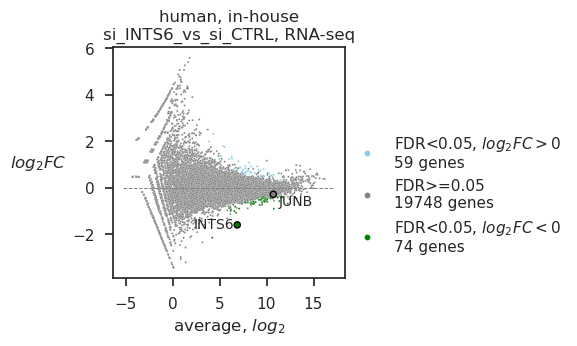

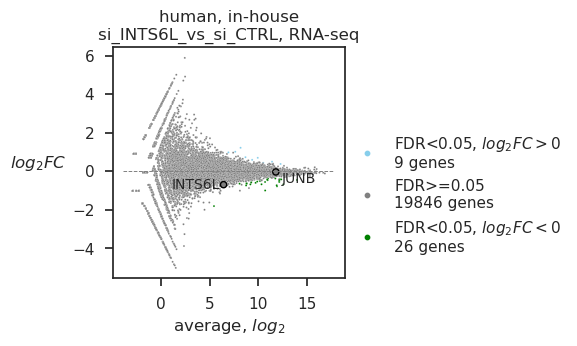

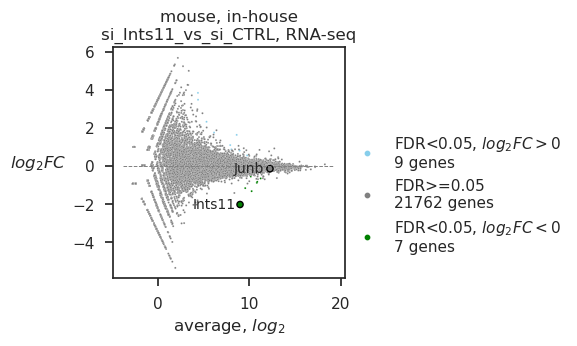

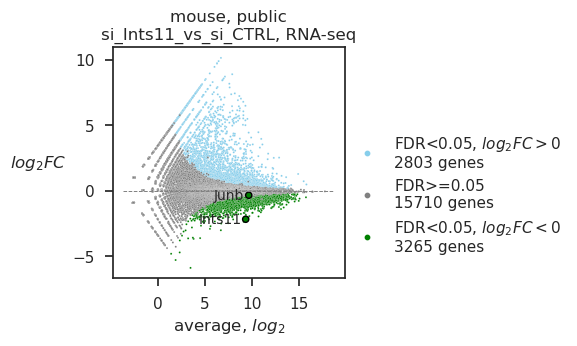

In [8]:
DE_dict = {}
for DE_analysis in res_dict:
    organism,batch,comparison = DE_analysis.split(';')
    targeted_gene_name = comparison.split('_vs_')[0].replace('si_','')

    genes_of_interest = {targeted_gene_name:targeted_gene_name,'JUNB':'JUNB','Junb':'Junb'}
    # genes_of_interest = {targeted_gene_name:targeted_gene_name}
    
    thr_significance = 0.05
    significance_feature = 'FDR'
    DE_table = pd.read_csv(res_dict[DE_analysis],delimiter="\t",index_col=None,header=0)
    DE_table = DE_table.rename(columns = {'gene_name':'gene_id'})
    DE_table = pd.merge(genes_dict[organism],DE_table,how='right',on='gene_id')
    # if human, intersect with Ints13
    if organism=='human':
        DE_table['ID'] = DE_table['gene_id'].str.split('.',expand=True)[0]
        DE_table = DE_table.loc[DE_table['ID'].isin(used_genes)].sort_values('gene_id').drop_duplicates('ID').drop('ID',1).reset_index(drop=True)
    
    # look only at protein-coding
    DE_table = DE_table.loc[DE_table['gene_type']=='protein_coding'].reset_index(drop=True)
    
    DE_table['log2FoldChange'] = DE_table['log2FoldChange'].fillna(0)
    DE_table[['pvalue','padj']] = DE_table[['pvalue','padj']].fillna(1)
    DE_table['FDR'] = multipletests(DE_table['pvalue'],method = 'fdr_bh')[1]
    DE_table['sign'] = (DE_table[significance_feature]<thr_significance).astype('int')
    map_dict = {-1:significance_feature+'<'+str(thr_significance)+', $log_2FC<0$',1:significance_feature+'<'+str(thr_significance)+', $log_2FC>0$',0:significance_feature+'>='+str(thr_significance)}
    DE_table['RNAseq_cat'] = (DE_table['sign']*((DE_table['log2FoldChange']>0).astype('int')*2-1)).map(map_dict)
    DE_table['log2_mean'] = np.log2(DE_table['baseMean'])
    

    data = DE_table.copy()
    data_to_show = data.loc[data['gene_name'].isin(genes_of_interest)].reset_index(drop=True)
    
    x_feature,y_feature,hue = 'log2_mean','log2FoldChange','RNAseq_cat'
    hue_order = [significance_feature+'<'+str(thr_significance)+', $log_2FC>0$',significance_feature+'>='+str(thr_significance),significance_feature+'<'+str(thr_significance)+', $log_2FC<0$']
    palette = ['skyblue','grey','green']
    
    sns.set(font_scale=1)
    sns.set_style("white")
    fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3),)
    
    ax = sns.scatterplot(data = data,x=x_feature,y=y_feature,hue=hue,s=2,hue_order = hue_order,palette = palette)
    ax = sns.scatterplot(data = data_to_show,x=x_feature,y=y_feature,hue=hue,s=20,edgecolor='black',linewidth=1,hue_order = hue_order,palette = palette,
                     alpha=1,legend=None)
    for index, row in data_to_show.iterrows():
        if genes_of_interest[row['gene_name']]=='JUNB':
            ax.text(row[x_feature]*1.05,row[y_feature],genes_of_interest[row['gene_name']],ha='left',va='top',size=10)
        else:
            ax.text(row[x_feature]*0.95,row[y_feature],genes_of_interest[row['gene_name']],ha='right',va='center',size=10)
        
    ax.set(xlabel = 'average, $log_2$',title=organism+', '+batch+'\n'+comparison+', RNA-seq')
    ax.set_ylabel(ylabel=r'$log_2FC$',rotation=0,ha='right',va='center',rotation_mode='anchor')
    ax.hlines(y=0,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1],color='grey',linestyles='--',linewidth=0.7)
    
    legend_labels = [elem+'\n'+str(len(data.loc[data[hue]==elem]))+' genes' for elem in hue_order]
    h, l = ax.get_legend_handles_labels()
    
    ax.legend(bbox_to_anchor=(1.001, 0.65),loc=2,borderaxespad=0.0,title='',markerscale=3,handles = h,labels = legend_labels)
    ax.tick_params(bottom=True,left=True)
    
    DE_dict[DE_analysis] = DE_table
    
    out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/'+'by_'+significance_feature+'/', shell=True)
    fig.savefig(subdirs['figures_dir']+'RNAseq/'+'by_'+significance_feature+'/'+'_'.join([organism,batch,comparison])+'_MA_plot.png',bbox_inches='tight',dpi=600)
    fig.savefig(subdirs['figures_dir']+'RNAseq/'+'by_'+significance_feature+'/'+'_'.join([organism,batch,comparison])+'_MA_plot.pdf',bbox_inches='tight',dpi=600)

## Compare Deseq2 with PROseq and bCLIP

In [9]:
DE_analysis = 'mouse;public;si_Ints11_vs_si_CTRL'
significance_feature = 'FDR'
bCLIP_replicates_to_show = ['Ints11C_replicate6','Ints10N_replicate1']
DE_table = DE_dict[DE_analysis]

data_PROseq = pd.read_csv(subdirs['tables_dir']+'PROseq_quantification/'+'PROseq.tsv',delimiter="\t",index_col=None,header=0)
data_PROseq['gene_name'] = data_PROseq['TSS'].str.split(';',expand=True)[0]

data_bCLIP = pd.read_csv(subdirs['tables_dir']+'bCLIP_quantification/'+'bCLIP.tsv',delimiter="\t",index_col=None,header=0)

intersection = pd.merge(data_PROseq,data_bCLIP[['TSS']+list(pd.Series(bCLIP_replicates_to_show)+';sign')],how='inner',on='TSS')
intersection = pd.merge(intersection,DE_table[['gene_name','log2_mean','log2FoldChange','RNAseq_cat']],how='left',on='gene_name')
bCLIP_samples = []
for sample in bCLIP_replicates_to_show:
    new_sample = sample.split('_')[0]+'+'
    bCLIP_samples.append(new_sample)
    intersection = intersection.rename(columns = {sample+';sign':new_sample})
intersection = intersection.dropna().reset_index(drop=True)

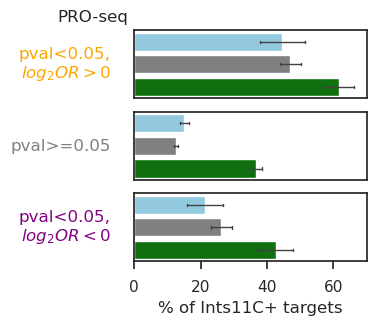

In [10]:
import textwrap
wrapper = textwrap.TextWrapper(width=10)

x_feature = 'PROseq_cat'
order = ['pval<'+str(thr_significance)+', $log_2OR>0$','pval>='+str(thr_significance),'pval<'+str(thr_significance)+', $log_2OR<0$']
palette = ['orange','grey','purple']
order_labels = ['pval<'+str(thr_significance)+',\n$log_2OR>0$','pval>='+str(thr_significance),'pval<'+str(thr_significance)+',\n$log_2OR<0$']

y_feature = 'Ints11C+'

hue = 'RNAseq_cat'
hue_order = [significance_feature+'<'+str(thr_significance)+', $log_2FC>0$',significance_feature+'>='+str(thr_significance),
             significance_feature+'<'+str(thr_significance)+', $log_2FC<0$']
hue_palette = ['skyblue','grey','green']

def func1(x):
    return 100*np.mean(x)+1

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(3,1,sharey=True,sharex=True, figsize=(3,3))

j=0
for cat in order:
    ax = sns.barplot(ax=axes[j],data = intersection.loc[intersection[x_feature]==cat], y=hue, x=y_feature, estimator=func1,
                order=hue_order,palette = hue_palette,hue=hue,hue_order=hue_order,
                orient='h',
                 capsize=0.1,errwidth=1)
    ax.legend([])
    # if j==1:
    #     ax.legend(bbox_to_anchor=(1.001, 1.2),loc=2,borderaxespad=0.0,title='RNA-seq',markerscale=3)
    ax.yaxis.label.set_color(palette[j])
    ax.set(yticklabels=[],xlabel='',xlim=(0,70))
    ax.set_ylabel(ylabel=order_labels[j],rotation=0,ha='right',va='center',rotation_mode='anchor')
    
    j=j+1
ax.set(xlabel='% of '+y_feature+' targets')
ax.tick_params(bottom=True)
fig.suptitle('PRO-seq', x=-0.13,y=0.95,size=12,ha='left',va='top')

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'association_between_RNA_seq_PRO_seq_and_bCLIP.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'association_between_RNA_seq_PRO_seq_and_bCLIP.pdf',bbox_inches='tight',dpi=600)

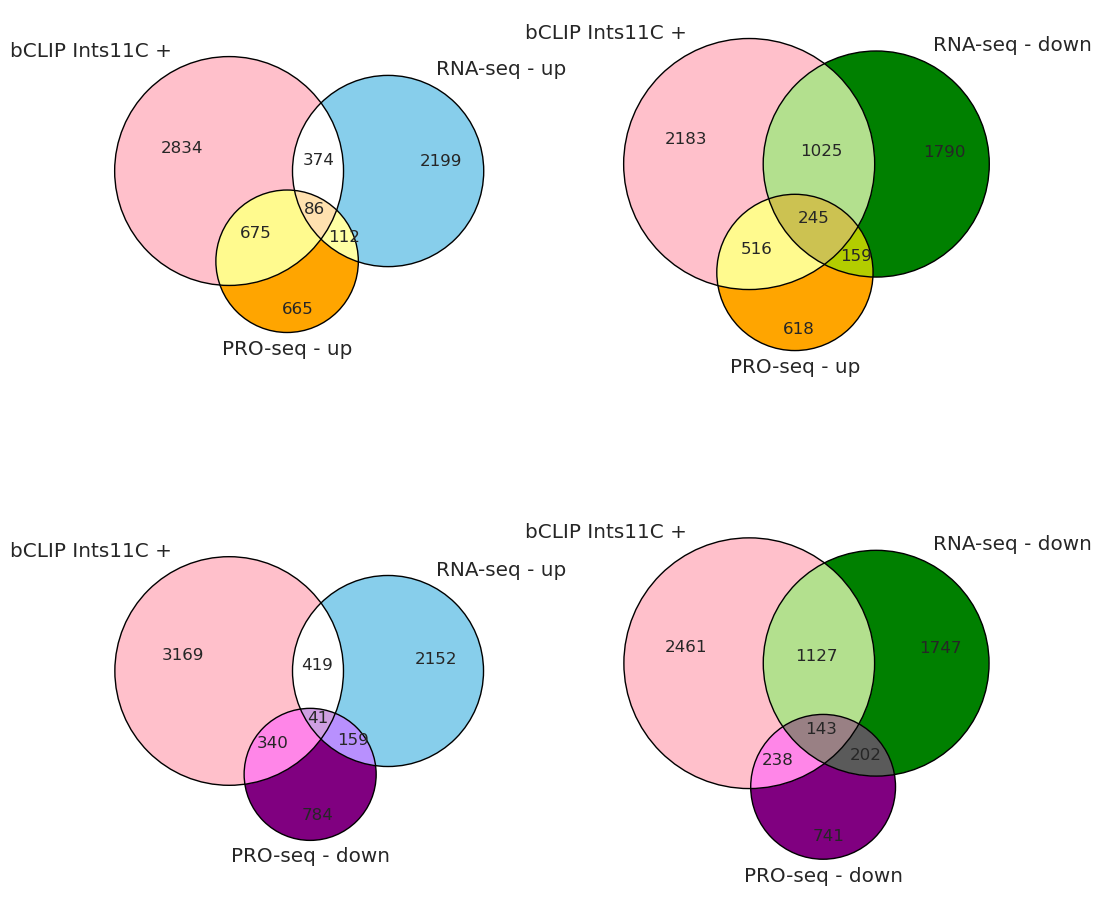

In [11]:
from matplotlib_venn import venn3,venn3_circles
from matplotlib_venn import venn2,venn2_circles

intersection['RNA-seq - down'] = (intersection['RNAseq_cat']==significance_feature+'<'+str(thr_significance)+', $log_2FC<0$').astype('int')
intersection['RNA-seq - up'] = (intersection['RNAseq_cat']==significance_feature+'<'+str(thr_significance)+', $log_2FC>0$').astype('int')
intersection['PRO-seq - up'] = (intersection['PROseq_cat']=='pval<'+str(thr_significance)+', $log_2OR>0$').astype('int')
intersection['PRO-seq - down'] = (intersection['PROseq_cat']=='pval<'+str(thr_significance)+', $log_2OR<0$').astype('int')

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False, figsize=(12,12))

# first
labels_of_interest = ['Ints11C+','RNA-seq - up','PRO-seq - up']
labels_to_show = ['bCLIP Ints11C +','RNA-seq - up','PRO-seq - up']
palette = ['pink','skyblue','orange']
ax = sns.scatterplot(ax=axes[0][0],data = None)
data = intersection.copy()

TSS_lists = []
for label in labels_of_interest:
    TSS_list = set(list(data.loc[data[label]==1]['TSS'].astype('str')))
    TSS_lists.append(TSS_list)
    
v = venn3(TSS_lists,set_labels=labels_to_show,set_colors=palette,ax=ax,alpha=1)
c = venn3_circles(TSS_lists,color='black',linewidth=1,ax=ax)

# second
labels_of_interest = ['Ints11C+','RNA-seq - down','PRO-seq - up']
labels_to_show = ['bCLIP Ints11C +','RNA-seq - down','PRO-seq - up']
palette = ['pink','green','orange']
ax = sns.scatterplot(ax=axes[0][1],data = None)
data = intersection.copy()

TSS_lists = []
for label in labels_of_interest:
    TSS_list = set(list(data.loc[data[label]==1]['TSS'].astype('str')))
    TSS_lists.append(TSS_list)
    
v = venn3(TSS_lists,set_labels=labels_to_show,set_colors=palette,ax=ax,alpha=1)
c = venn3_circles(TSS_lists,color='black',linewidth=1,ax=ax)

# third
labels_of_interest = ['Ints11C+','RNA-seq - up','PRO-seq - down']
labels_to_show = ['bCLIP Ints11C +','RNA-seq - up','PRO-seq - down']
palette = ['pink','skyblue','purple']
ax = sns.scatterplot(ax=axes[1][0],data = None)
data = intersection.copy()

TSS_lists = []
for label in labels_of_interest:
    TSS_list = set(list(data.loc[data[label]==1]['TSS'].astype('str')))
    TSS_lists.append(TSS_list)
    
v = venn3(TSS_lists,set_labels=labels_to_show,set_colors=palette,ax=ax,alpha=1)
c = venn3_circles(TSS_lists,color='black',linewidth=1,ax=ax)

# forth
labels_of_interest = ['Ints11C+','RNA-seq - down','PRO-seq - down']
labels_to_show = ['bCLIP Ints11C +','RNA-seq - down','PRO-seq - down']
palette = ['pink','green','purple']
ax = sns.scatterplot(ax=axes[1][1],data = None)
data = intersection.copy()

TSS_lists = []
for label in labels_of_interest:
    TSS_list = set(list(data.loc[data[label]==1]['TSS'].astype('str')))
    TSS_lists.append(TSS_list)
    
v = venn3(TSS_lists,set_labels=labels_to_show,set_colors=palette,ax=ax,alpha=1)
c = venn3_circles(TSS_lists,color='black',linewidth=1,ax=ax)

# fig.tight_layout(pad=5.5)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/Vienn_Diagrams.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/Vienn_Diagrams.pdf',bbox_inches='tight',dpi=600)

In [12]:
# make heatmap with Jaccard similarity
RNAseq_cat_dict = {'FDR<0.05, $log_2FC>0$':1,'FDR>=0.05':0,'FDR<0.05, $log_2FC<0$':-1}
intersection['RNAseq_cat_int'] = intersection['RNAseq_cat'].map(RNAseq_cat_dict)
PROseq_cat_dict = {'pval<0.05, $log_2OR>0$':1, 'pval>=0.05':0, 'pval<0.05, $log_2OR<0$':-1}
intersection['PROseq_cat_int'] = intersection['PROseq_cat'].map(PROseq_cat_dict)


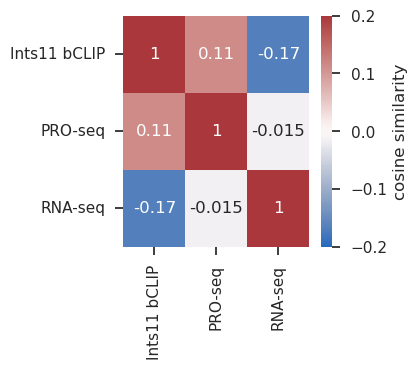

In [13]:
list_of_features = ['Ints11C+','PROseq_cat_int','RNAseq_cat_int']
feature_labels = ['Ints11 bCLIP','PRO-seq','RNA-seq']
from sklearn.metrics.pairwise import pairwise_distances
A = 1 - pairwise_distances(intersection[list_of_features].T.to_numpy(), metric='cosine')
A = pd.DataFrame(A,columns = feature_labels)
A.index = feature_labels

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3))

ax = sns.heatmap(A,cbar_kws={'label': 'cosine similarity'},vmin=-0.2,vmax=0.2,center=0,cmap=sns.color_palette('vlag',as_cmap=True),annot=True)
ax.set(xlabel="", ylabel="")

ax.tick_params(bottom=True,left=True)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/cosine_similarity.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/cosine_similarity.pdf',bbox_inches='tight',dpi=600)

In [14]:
targets_plus_plus_plus = intersection.loc[(intersection['Ints11C+']==1)&(intersection['PROseq_cat_int']==1)&(intersection['RNAseq_cat_int']==1)][['gene_name']].drop_duplicates()
targets_plus_plus_minus = intersection.loc[(intersection['Ints11C+']==1)&(intersection['PROseq_cat_int']==1)&(intersection['RNAseq_cat_int']==-1)][['gene_name']].drop_duplicates()
targets_plus_minus_plus = intersection.loc[(intersection['Ints11C+']==1)&(intersection['PROseq_cat_int']==-1)&(intersection['RNAseq_cat_int']==1)][['gene_name']].drop_duplicates()
targets_plus_minus_minus = intersection.loc[(intersection['Ints11C+']==1)&(intersection['PROseq_cat_int']==-1)&(intersection['RNAseq_cat_int']==-1)][['gene_name']].drop_duplicates()
background = intersection[['gene_name']].drop_duplicates()

targets_plus_plus_plus.to_csv(subdirs['tables_dir']+'GO_enrichment/targets_plus_plus_plus.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_plus_plus_minus.to_csv(subdirs['tables_dir']+'GO_enrichment/targets_plus_plus_minus.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_plus_minus_plus.to_csv(subdirs['tables_dir']+'GO_enrichment/targets_plus_minus_plus.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_plus_minus_minus.to_csv(subdirs['tables_dir']+'GO_enrichment/targets_plus_minus_minus.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
background.to_csv(subdirs['tables_dir']+'GO_enrichment/bclip_background.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

['Ints1',
 'Ints2',
 'Ints3',
 'Ints4',
 'Ints5',
 'Ints6',
 'Ints7',
 'Ints8',
 'Ints9',
 'Ints10',
 'Ints11',
 'Ints12',
 'Ints13']

In [27]:
TSS_summary = intersection[['TSS','gene_name','Ints11C+','Ints10N+','PROseq_cat_int','RNAseq_cat_int']]
TSS_summary.to_csv(subdirs['tables_dir']+'TSS_summary.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

genes_of_interest = ['Junb','Ddx11']+list('Ints'+pd.Series(range(1,14)).astype('str'))+list('Ints'+pd.Series(range(1,14)).astype('str')+'l')
TSS_summary_filtered = TSS_summary.loc[TSS_summary['gene_name'].isin(genes_of_interest)].reset_index(drop=True)
sort_dict = {}
i=0
for elem in genes_of_interest:
    sort_dict[elem]=i
    i=i+1
TSS_summary_filtered['order'] = TSS_summary_filtered['gene_name'].map(sort_dict)
TSS_summary_filtered = TSS_summary_filtered.sort_values('order').reset_index(drop=True)
TSS_summary_filtered = TSS_summary_filtered.drop('order',1)
TSS_summary_filtered.to_csv(subdirs['tables_dir']+'TSS_summary_filtered.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)
TSS_summary_filtered

,TSS,gene_name,Ints11C+,Ints10N+,PROseq_cat_int,RNAseq_cat_int
0,Junb;85705347,Junb,1,1,1,-1
1,Ddx11;66430515,Ddx11,1,1,1,-1
2,Ints1;139761429,Ints1,0,0,1,0
3,Ints2;86148401,Ints2,1,0,0,0
4,Ints3;90340929,Ints3,1,0,0,1
5,Ints4;97130163,Ints4,1,0,0,-1
6,Ints5;8870369,Ints5,0,0,0,0
7,Ints6;62998618,Ints6,1,1,0,0
8,Ints7;191307748,Ints7,0,0,0,0
9,Ints8;11254258,Ints8,1,1,1,0


## Compare Deseq2 Ints6, Ints6L, and Ints13

In [9]:
significance_feature = 'pvalue'
thr_significance = 0.05
DE_analysis_1 = 'human;in-house;si_INTS6_vs_si_CTRL'
DE_analysis_2 = 'human;in-house;si_INTS6L_vs_si_CTRL'
DE_table_1 = DE_dict[DE_analysis_1]
DE_table_2 = DE_dict[DE_analysis_2]

In [10]:
# make MA-plot for Ints13
DE_table_Ints13 = pd.read_csv(subdirs['tables_dir']+'Deseq2/results_DESeq_ints13_Depletion_vs_negctrl.tsv',delimiter="\t",index_col=None,header=0)
used_genes = list(DE_table_1['gene_id'].str.split('.',expand=True)[0].unique())
DE_table_Ints13 = DE_table_Ints13.loc[DE_table_Ints13['ID'].isin(used_genes)].drop_duplicates('ID').reset_index(drop=True)

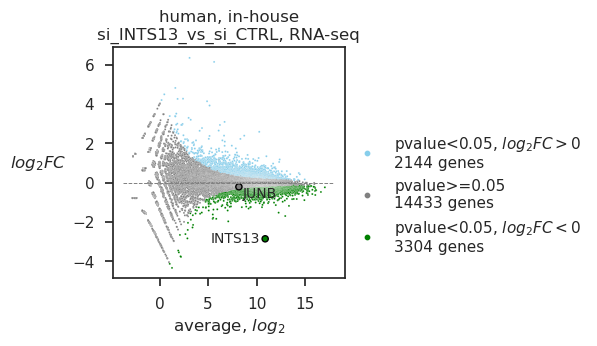

In [11]:
targeted_gene_name = 'INTS13'
# genes_of_interest = {targeted_gene_name:targeted_gene_name}
genes_of_interest = {targeted_gene_name:targeted_gene_name,'JUNB':'JUNB','Junb':'Junb'}

DE_table_Ints13['sign'] = (DE_table_Ints13[significance_feature]<thr_significance).astype('int')
map_dict = {-1:significance_feature+'<'+str(thr_significance)+', $log_2FC<0$',1:significance_feature+'<'+str(thr_significance)+', $log_2FC>0$',0:significance_feature+'>='+str(thr_significance)}
DE_table_Ints13['RNAseq_cat'] = (DE_table_Ints13['sign']*((DE_table_Ints13['log2FoldChange']>0).astype('int')*2-1)).map(map_dict)
DE_table_Ints13['log2_mean'] = np.log2(DE_table_Ints13['baseMean'])

data = DE_table_Ints13.copy()
data_to_show = data.loc[data['gene_name'].isin(genes_of_interest)].reset_index(drop=True)

x_feature,y_feature,hue = 'log2_mean','log2FoldChange','RNAseq_cat'
hue_order = [significance_feature+'<'+str(thr_significance)+', $log_2FC>0$',significance_feature+'>='+str(thr_significance),significance_feature+'<'+str(thr_significance)+', $log_2FC<0$']
palette = ['skyblue','grey','green']

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3),)

ax = sns.scatterplot(data = data,x=x_feature,y=y_feature,hue=hue,s=2,hue_order = hue_order,palette = palette)
ax = sns.scatterplot(data = data_to_show,x=x_feature,y=y_feature,hue=hue,s=20,edgecolor='black',linewidth=1,hue_order = hue_order,palette = palette,
                 alpha=1,legend=None)
for index, row in data_to_show.iterrows():
    if genes_of_interest[row['gene_name']]=='JUNB':
        ax.text(row[x_feature]*1.05,row[y_feature],genes_of_interest[row['gene_name']],ha='left',va='top',size=10)
    else:
        ax.text(row[x_feature]*0.95,row[y_feature],genes_of_interest[row['gene_name']],ha='right',va='center',size=10)
    
ax.set(xlabel = 'average, $log_2$',title='human, in-house\n'+'si_INTS13_vs_si_CTRL, RNA-seq')
ax.set_ylabel(ylabel=r'$log_2FC$',rotation=0,ha='right',va='center',rotation_mode='anchor')
ax.hlines(y=0,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1],color='grey',linestyles='--',linewidth=0.7)

legend_labels = [elem+'\n'+str(len(data.loc[data[hue]==elem]))+' genes' for elem in hue_order]
h, l = ax.get_legend_handles_labels()

ax.legend(bbox_to_anchor=(1.001, 0.65),loc=2,borderaxespad=0.0,title='',markerscale=3,handles = h,labels = legend_labels)
ax.tick_params(bottom=True,left=True)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/'+'by_'+significance_feature+'/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'by_'+significance_feature+'/'+'human_in-house_'+'si_INTS13_vs_si_CTRL'+'_MA_plot.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'by_'+significance_feature+'/'+'human_in-house_'+'si_INTS13_vs_si_CTRL'+'_MA_plot.pdf',bbox_inches='tight',dpi=600)

In [12]:
DE_table_3 = DE_table_Ints13.copy()

In [14]:
len(DE_table_1),len(DE_table_2),len(DE_table_3)

(19881, 19881, 19881)

In [15]:
# first, Ints6 vs 6L
RNAseq_cat_dict = {significance_feature+'<0.05, $log_2FC>0$':1,significance_feature+'>=0.05':0,significance_feature+'<0.05, $log_2FC<0$':-1}

features_of_interest = ['log2FoldChange','pvalue','minus_log_pval','RNAseq_cat']
experiment_labels = ['si INTS6','si INTS6L','si INTS13']

i=0
for DE_table in [DE_table_1,DE_table_2,DE_table_3]:
    data = DE_table.copy()
    if 'ID' not in list(data.columns):
        data['ID'] = data['gene_id'].str.split('.',expand=True)[0]
    data = data.sort_values('ID').drop_duplicates('ID').reset_index(drop=True)
    data['minus_log_pval'] = (-1)*np.log10(data['pvalue']+10**(-20))*((data['log2FoldChange']>0).astype('int')*2-1)
    data['RNAseq_cat'] = data['RNAseq_cat'].map(RNAseq_cat_dict)
    rename_dict = {}
    for feature in features_of_interest:
        rename_dict[feature] = feature+'_'+str(i+1)
    if i==0:
        intersection = data[['ID','gene_name']+features_of_interest].rename(columns = rename_dict)
    else:
        intersection = pd.merge(intersection,data[['ID']+features_of_interest].rename(columns = rename_dict),how='inner',on=['ID'])
    i=i+1
intersection = intersection.dropna().reset_index(drop=True)

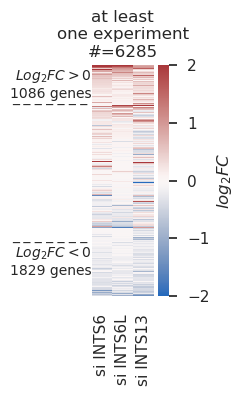

In [434]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(1,3))

feature = 'log2FoldChange'

genes_of_interest = {'JUNB':'JUNB'}

data = intersection.loc[abs(intersection['RNAseq_cat_1'])+abs(intersection['RNAseq_cat_2'])+abs(intersection['RNAseq_cat_3'])>=1].reset_index(drop=True)
data['av_cat'] =((data['log2FoldChange_1']>0).astype('int')*2-1)+((data['log2FoldChange_2']>0).astype('int')*2-1)+((data['log2FoldChange_3']>0).astype('int')*2-1)
data['av_effect'] = data[[feature+'_1',feature+'_2',feature+'_3']].median(1)
data = data.sort_values(['av_cat','av_effect'],ascending=[False,False]).reset_index(drop=True)

data['all_up'] = ((data['log2FoldChange_1']>0).astype('int')+(data['log2FoldChange_2']>0).astype('int')+(data['log2FoldChange_3']>0).astype('int')==3).astype('int')
data['all_down'] = ((data['log2FoldChange_1']<0).astype('int')+(data['log2FoldChange_2']<0).astype('int')+(data['log2FoldChange_3']<0).astype('int')==3).astype('int')

data_to_show = data.loc[data['gene_name'].isin(genes_of_interest)]

ax = sns.heatmap(data[[feature+'_1',feature+'_2',feature+'_3']],cbar_kws={'label': '$log_2FC$','aspect':20},vmin=-2,vmax=2,center=0,cmap=sns.color_palette('vlag',as_cmap=True))
ax.set(xticklabels=experiment_labels,ylabel='',yticks=[],title='at least\none experiment\n#='+str(len(data)))

# for index, row in data_to_show.iterrows():
#     ax.text(0,index,'< '+genes_of_interest[row['gene_name']],ha='left',va='center',size=10)

y_pos = np.max(list(data.loc[data['all_up']==1].index))
ax.text(0,y_pos,'_ _ _ _ _ _ _ ',ha='right',va='bottom',size=10)
ax.text(0,y_pos*0.9,'$Log_2FC>0$\n'+str(len(data.loc[data['all_up']==1]))+' genes',ha='right',va='bottom',size=10)

y_pos = np.min(list(data.loc[data['all_down']==1].index))
ax.text(0,y_pos,'_ _ _ _ _ _ _ ',ha='right',va='top',size=10)
ax.text(0,y_pos*1.1,'$Log_2FC<0$\n'+str(len(data.loc[data['all_down']==1]))+' genes',ha='right',va='top',size=10)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_vs_11_heatmap.1.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_vs_11_heatmap.1.pdf',bbox_inches='tight',dpi=600)

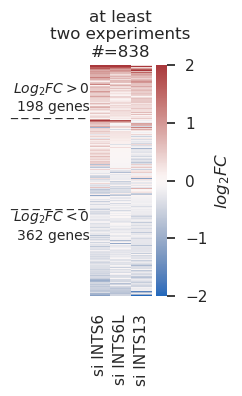

In [510]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(1,3))

feature = 'log2FoldChange'

genes_of_interest = {'JUNB':'JUNB'}

data = intersection.loc[abs(intersection['RNAseq_cat_1'])+abs(intersection['RNAseq_cat_2'])+abs(intersection['RNAseq_cat_3'])>=2].reset_index(drop=True)
data['av_cat'] =((data['log2FoldChange_1']>0).astype('int')*2-1)+((data['log2FoldChange_2']>0).astype('int')*2-1)+((data['log2FoldChange_3']>0).astype('int')*2-1)
data['av_effect'] = data[[feature+'_1',feature+'_2',feature+'_3']].median(1)
data = data.sort_values(['av_cat','av_effect'],ascending=[False,False]).reset_index(drop=True)

data['all_up'] = ((data['log2FoldChange_1']>0).astype('int')+(data['log2FoldChange_2']>0).astype('int')+(data['log2FoldChange_3']>0).astype('int')==3).astype('int')
data['all_down'] = ((data['log2FoldChange_1']<0).astype('int')+(data['log2FoldChange_2']<0).astype('int')+(data['log2FoldChange_3']<0).astype('int')==3).astype('int')

data_to_show = data.loc[data['gene_name'].isin(genes_of_interest)]

ax = sns.heatmap(data[[feature+'_1',feature+'_2',feature+'_3']],cbar_kws={'label': '$log_2FC$','aspect':20},vmin=-2,vmax=2,center=0,cmap=sns.color_palette('vlag',as_cmap=True))
ax.set(xticklabels=experiment_labels,ylabel='',yticks=[],title='at least\ntwo experiments\n#='+str(len(data)))

# for index, row in data_to_show.iterrows():
#     ax.text(0,index,'< '+genes_of_interest[row['gene_name']],ha='left',va='center',size=10)

y_pos = np.max(list(data.loc[data['all_up']==1].index))
ax.text(0,y_pos,'_ _ _ _ _ _ _ ',ha='right',va='bottom',size=10)
ax.text(0,y_pos*0.9,'$Log_2FC>0$\n'+str(len(data.loc[data['all_up']==1]))+' genes',ha='right',va='bottom',size=10)

y_pos = np.min(list(data.loc[data['all_down']==1].index))
ax.text(0,y_pos,'_ _ _ _ _ _ _ ',ha='right',va='top',size=10)
ax.text(0,y_pos*1.1,'$Log_2FC<0$\n'+str(len(data.loc[data['all_down']==1]))+' genes',ha='right',va='top',size=10)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_vs_11_heatmap.2.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_vs_11_heatmap.2.pdf',bbox_inches='tight',dpi=600)

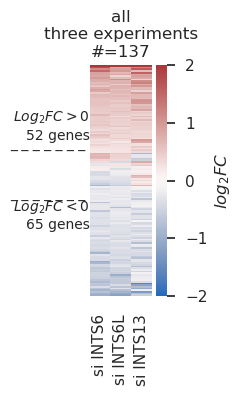

In [440]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(1,3))

feature = 'log2FoldChange'

genes_of_interest = {'JUNB':'JUNB'}

data = intersection.loc[abs(intersection['RNAseq_cat_1'])+abs(intersection['RNAseq_cat_2'])+abs(intersection['RNAseq_cat_3'])>=3].reset_index(drop=True)
data['av_cat'] =((data['log2FoldChange_1']>0).astype('int')*2-1)+((data['log2FoldChange_2']>0).astype('int')*2-1)+((data['log2FoldChange_3']>0).astype('int')*2-1)
data['av_effect'] = data[[feature+'_1',feature+'_2',feature+'_3']].median(1)
data = data.sort_values(['av_cat','av_effect'],ascending=[False,False]).reset_index(drop=True)

data['all_up'] = ((data['log2FoldChange_1']>0).astype('int')+(data['log2FoldChange_2']>0).astype('int')+(data['log2FoldChange_3']>0).astype('int')==3).astype('int')
data['all_down'] = ((data['log2FoldChange_1']<0).astype('int')+(data['log2FoldChange_2']<0).astype('int')+(data['log2FoldChange_3']<0).astype('int')==3).astype('int')

data_to_show = data.loc[data['gene_name'].isin(genes_of_interest)]

ax = sns.heatmap(data[[feature+'_1',feature+'_2',feature+'_3']],cbar_kws={'label': '$log_2FC$','aspect':20},vmin=-2,vmax=2,center=0,cmap=sns.color_palette('vlag',as_cmap=True))
ax.set(xticklabels=experiment_labels,ylabel='',yticks=[],title='all\nthree experiments\n#='+str(len(data)))

# for index, row in data_to_show.iterrows():
#     ax.text(0,index,'< '+genes_of_interest[row['gene_name']],ha='left',va='center',size=10)

y_pos = np.max(list(data.loc[data['all_up']==1].index))
ax.text(0,y_pos,'_ _ _ _ _ _ _ ',ha='right',va='bottom',size=10)
ax.text(0,y_pos*0.9,'$Log_2FC>0$\n'+str(len(data.loc[data['all_up']==1]))+' genes',ha='right',va='bottom',size=10)

y_pos = np.min(list(data.loc[data['all_down']==1].index))
ax.text(0,y_pos,'_ _ _ _ _ _ _ ',ha='right',va='top',size=10)
ax.text(0,y_pos*1.1,'$Log_2FC<0$\n'+str(len(data.loc[data['all_down']==1]))+' genes',ha='right',va='top',size=10)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_vs_11_heatmap.3.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_vs_11_heatmap.3.pdf',bbox_inches='tight',dpi=600)

In [505]:
data = intersection.loc[abs(intersection['RNAseq_cat_1'])+abs(intersection['RNAseq_cat_2'])+abs(intersection['RNAseq_cat_3'])>=2].reset_index(drop=True)
data['all_up'] = ((data['log2FoldChange_1']>0).astype('int')+(data['log2FoldChange_2']>0).astype('int')+(data['log2FoldChange_3']>0).astype('int')==3).astype('int')
data['all_down'] = ((data['log2FoldChange_1']<0).astype('int')+(data['log2FoldChange_2']<0).astype('int')+(data['log2FoldChange_3']<0).astype('int')==3).astype('int')

In [506]:
len(data.loc[data['all_up']==1]),len(data.loc[data['all_down']==1])

(198, 362)

In [508]:
all_up = data.loc[data['all_up']==1][['gene_name']].reset_index(drop=True)
all_down = data.loc[data['all_down']==1][['gene_name']].reset_index(drop=True)
background = intersection.loc[~intersection['gene_name'].isin(list(all_up['gene_name'])+list(all_down['gene_name']))][['gene_name']].reset_index(drop=True)

all_up.to_csv(subdirs['tables_dir']+'GO_enrichment/all_up.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
all_down.to_csv(subdirs['tables_dir']+'GO_enrichment/all_down.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
background.to_csv(subdirs['tables_dir']+'GO_enrichment/background.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

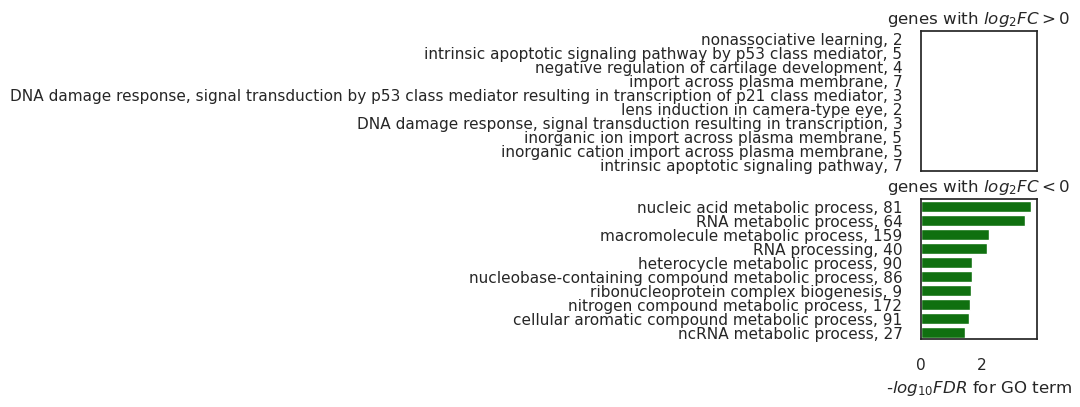

In [532]:
# show GO terms
ALL_up = pd.read_csv(subdirs['tables_dir']+'GO_enrichment/ALL_up;GOPROCESS.tsv',delimiter="\t",index_col=None,header=0)
ALL_down = pd.read_csv(subdirs['tables_dir']+'GO_enrichment/ALL_down;GOPROCESS.tsv',delimiter="\t",index_col=None,header=0)

ALL_up['Description'] = ALL_up['Description']+', '+ALL_up['b'].astype('str')
ALL_down['Description'] = ALL_down['Description']+', '+ALL_down['b'].astype('str')

ALL_up['score'] = (-1)*np.log10(ALL_up['FDR q-value'])
ALL_down['score'] = (-1)*np.log10(ALL_down['FDR q-value'])

x_feature,y_feature ='score','Description'
x_label,y_label = '-$log_{10}FDR$ for GO term',''

ALL_down = ALL_down.sort_values(x_feature,ascending=False).head(10)
ALL_up = ALL_up.sort_values(x_feature,ascending=False).head(10)
colors = ['skyblue','green']

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(1.5,4))

j=0
ax = sns.barplot(ax=axes[j],data=ALL_up,x=x_feature,y=y_feature,color=colors[j])
# ax.yaxis.tick_right()
ax.set(xlabel = x_label,ylabel = y_label,title='genes with $log_2FC>0$')

j=1
ax = sns.barplot(ax=axes[j],data=ALL_down,x=x_feature,y=y_feature,color=colors[j])
ax.set(xlabel = x_label,ylabel = y_label,title='genes with $log_2FC<0$')

fig.tight_layout(pad=0.001)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'top_GO_terms.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'top_GO_terms.pdf',bbox_inches='tight',dpi=600)

In [535]:
intersection.to_csv(subdirs['tables_dir']+'Deseq2/intersection_of_three_experiments.tsv',sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)

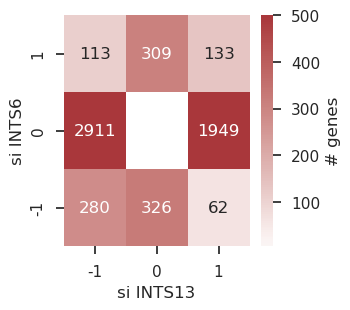

In [20]:
intersection['t']=1
gr = intersection.groupby(['RNAseq_cat_1','RNAseq_cat_3']).agg({'t':np.sum}).reset_index()
gr1 = gr.loc[(gr['RNAseq_cat_1']!=0)|(gr['RNAseq_cat_3']!=0)].reset_index(drop=True)
gr1 = pd.pivot_table(gr1,index = 'RNAseq_cat_1',columns='RNAseq_cat_3')
gr1.columns = gr1.columns.droplevel()
gr1 = gr1.sort_index(ascending=False)

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3))

ax = sns.heatmap(gr1,cbar_kws={'label': '# genes'},vmin=5,vmax=500,center=0,cmap=sns.color_palette('vlag',as_cmap=True),annot=True, fmt=".0f")
ax.set(xlabel='si INTS13', ylabel='si INTS6')
ax.tick_params(bottom=True,left=True)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_13_heatmap.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_13_heatmap.pdf',bbox_inches='tight',dpi=600)

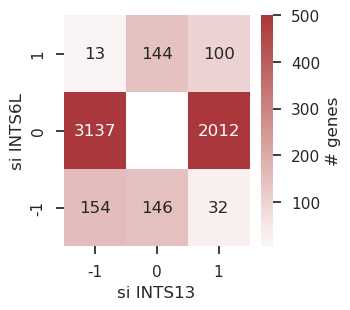

In [21]:
intersection['t']=1
gr = intersection.groupby(['RNAseq_cat_2','RNAseq_cat_3']).agg({'t':np.sum}).reset_index()
gr1 = gr.loc[(gr['RNAseq_cat_2']!=0)|(gr['RNAseq_cat_3']!=0)].reset_index(drop=True)
gr1 = pd.pivot_table(gr1,index = 'RNAseq_cat_2',columns='RNAseq_cat_3')
gr1.columns = gr1.columns.droplevel()
gr1 = gr1.sort_index(ascending=False)

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3))

ax = sns.heatmap(gr1,cbar_kws={'label': '# genes'},vmin=5,vmax=500,center=0,cmap=sns.color_palette('vlag',as_cmap=True),annot=True, fmt=".0f")
ax.set(xlabel='si INTS13', ylabel='si INTS6L')
ax.tick_params(bottom=True,left=True)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6L_vs_13_heatmap.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6L_vs_13_heatmap.pdf',bbox_inches='tight',dpi=600)

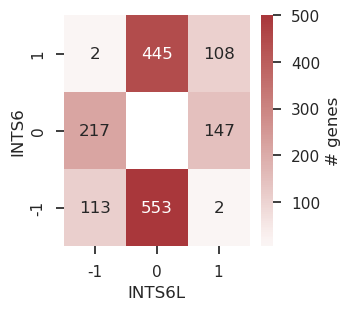

In [22]:
intersection['t']=1
gr = intersection.groupby(['RNAseq_cat_1','RNAseq_cat_2']).agg({'t':np.sum}).reset_index()
gr1 = gr.loc[(gr['RNAseq_cat_1']!=0)|(gr['RNAseq_cat_2']!=0)].reset_index(drop=True)
gr1 = pd.pivot_table(gr1,index = 'RNAseq_cat_1',columns='RNAseq_cat_2')
gr1.columns = gr1.columns.droplevel()
gr1 = gr1.sort_index(ascending=False)

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3))

ax = sns.heatmap(gr1,cbar_kws={'label': '# genes'},vmin=5,vmax=500,center=0,cmap=sns.color_palette('vlag',as_cmap=True),annot=True, fmt=".0f")
ax.set(xlabel='INTS6L', ylabel='INTS6')
ax.tick_params(bottom=True,left=True)
out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_heatmap.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/'+'INTS6_vs_6L_heatmap.pdf',bbox_inches='tight',dpi=600)

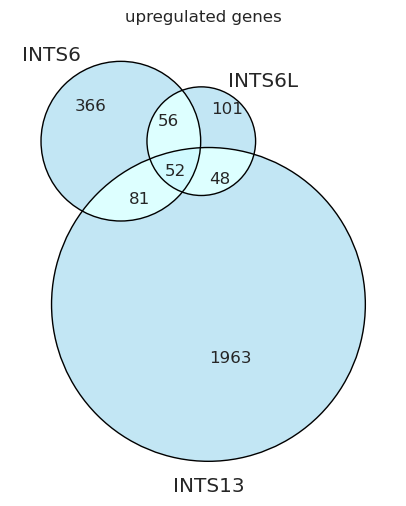

In [58]:
# 6L vs 6 vs 13 - downregulation

from matplotlib_venn import venn3,venn3_circles
from matplotlib_venn import venn2,venn2_circles

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(6,6))

labels_to_show = ['INTS6','INTS6L','INTS13']

ax = sns.scatterplot(data = None)
ax.set(title='upregulated genes')

gene_lists = []
for label in ['RNAseq_cat_1','RNAseq_cat_2','RNAseq_cat_3']:
    gene_list = set(list(intersection.loc[intersection[label]==1]['gene_name']))
    gene_lists.append(gene_list)

v = venn3(gene_lists,set_labels=labels_to_show,set_colors=['skyblue']*3,ax=ax,alpha=0.5)
c = venn3_circles(gene_lists,color='black',linewidth=1,ax=ax)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/Vienn_Diagram_upregulate.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/Vienn_Diagram_upregulate.pdf',bbox_inches='tight',dpi=600)

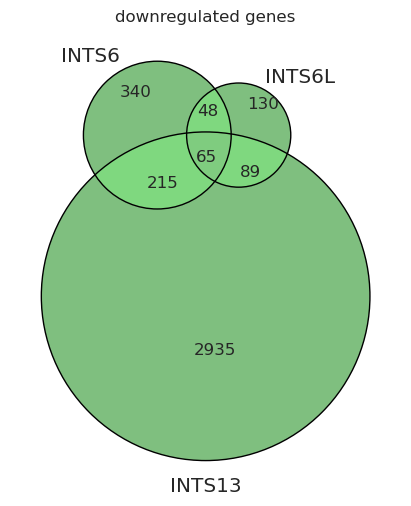

In [46]:
# 6L vs 6 vs 13 - upregulation

from matplotlib_venn import venn3,venn3_circles
from matplotlib_venn import venn2,venn2_circles

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(6,6))

labels_to_show = ['INTS6','INTS6L','INTS13']

ax = sns.scatterplot(data = None)
ax.set(title='downregulated genes')

gene_lists = []
for label in ['RNAseq_cat_1','RNAseq_cat_2','RNAseq_cat_3']:
    gene_list = set(list(intersection.loc[intersection[label]==-1]['gene_name']))
    gene_lists.append(gene_list)

v = venn3(gene_lists,set_labels=labels_to_show,set_colors=['green']*3,ax=ax,alpha=0.5)
c = venn3_circles(gene_lists,color='black',linewidth=1,ax=ax)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/Vienn_Diagram_downregulate.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/Vienn_Diagram_downregulate.pdf',bbox_inches='tight',dpi=600)

In [53]:
# downregulation
data = intersection.copy()

targets_6_specific = data.loc[(data['RNAseq_cat_1']==-1)&(data['RNAseq_cat_2']!=-1)&(data['RNAseq_cat_3']!=-1)][['gene_name']].reset_index(drop=True)
targets_6L_specific = data.loc[(data['RNAseq_cat_1']!=-1)&(data['RNAseq_cat_2']==-1)&(data['RNAseq_cat_3']!=-1)][['gene_name']].reset_index(drop=True)
targets_13_specific = data.loc[(data['RNAseq_cat_1']!=-1)&(data['RNAseq_cat_2']!=-1)&(data['RNAseq_cat_3']==-1)][['gene_name']].reset_index(drop=True)
targets_6_13_specific = data.loc[(data['RNAseq_cat_1']==-1)&(data['RNAseq_cat_2']!=-1)&(data['RNAseq_cat_3']==-1)][['gene_name']].reset_index(drop=True)
targets_6L_13_specific = data.loc[(data['RNAseq_cat_1']!=-1)&(data['RNAseq_cat_2']==-1)&(data['RNAseq_cat_3']==-1)][['gene_name']].reset_index(drop=True)
targets_6L_6_specific = data.loc[(data['RNAseq_cat_1']==-1)&(data['RNAseq_cat_2']==-1)&(data['RNAseq_cat_3']!=-1)][['gene_name']].reset_index(drop=True)
targets_6L_6_13_specific = data.loc[(data['RNAseq_cat_1']==-1)&(data['RNAseq_cat_2']==-1)&(data['RNAseq_cat_3']==-1)][['gene_name']].reset_index(drop=True)
background = data[['gene_name']].reset_index(drop=True)

targets_6_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.6_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.6L_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.6_13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.6L_13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_6_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.6L_6_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_6_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/down.6L_6_13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
background.to_csv(subdirs['tables_dir']+'GO_enrichment/down.background.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

In [55]:
# upregulation
data = intersection.copy()

targets_6_specific = data.loc[(data['RNAseq_cat_1']==1)&(data['RNAseq_cat_2']!=1)&(data['RNAseq_cat_3']!=1)][['gene_name']].reset_index(drop=True)
targets_6L_specific = data.loc[(data['RNAseq_cat_1']!=1)&(data['RNAseq_cat_2']==1)&(data['RNAseq_cat_3']!=1)][['gene_name']].reset_index(drop=True)
targets_13_specific = data.loc[(data['RNAseq_cat_1']!=1)&(data['RNAseq_cat_2']!=1)&(data['RNAseq_cat_3']==1)][['gene_name']].reset_index(drop=True)
targets_6_13_specific = data.loc[(data['RNAseq_cat_1']==1)&(data['RNAseq_cat_2']!=1)&(data['RNAseq_cat_3']==1)][['gene_name']].reset_index(drop=True)
targets_6L_13_specific = data.loc[(data['RNAseq_cat_1']!=1)&(data['RNAseq_cat_2']==1)&(data['RNAseq_cat_3']==1)][['gene_name']].reset_index(drop=True)
targets_6L_6_specific = data.loc[(data['RNAseq_cat_1']==1)&(data['RNAseq_cat_2']==1)&(data['RNAseq_cat_3']!=1)][['gene_name']].reset_index(drop=True)
targets_6L_6_13_specific = data.loc[(data['RNAseq_cat_1']==1)&(data['RNAseq_cat_2']==1)&(data['RNAseq_cat_3']==1)][['gene_name']].reset_index(drop=True)
background = data[['gene_name']].reset_index(drop=True)

targets_6_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.6_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.6L_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.6_13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.6L_13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_6_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.6L_6_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_6_13_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/up.6L_6_13_spec.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
background.to_csv(subdirs['tables_dir']+'GO_enrichment/up.background.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

In [28]:
# 6L vs 6 - downregulation
data = intersection.copy()

targets_6_specific = data.loc[(data['RNAseq_cat_1']==-1)&(data['RNAseq_cat_2']==0)][['gene_name']].reset_index(drop=True)
targets_6L_specific = data.loc[(data['RNAseq_cat_1']==0)&(data['RNAseq_cat_2']==-1)][['gene_name']].reset_index(drop=True)
targets_common = data.loc[(data['RNAseq_cat_1']==-1)&(data['RNAseq_cat_2']==-1)][['gene_name']].reset_index(drop=True)
background = data.loc[~data['gene_name'].isin(list(targets_6_specific['gene_name'])+list(targets_6L_specific['gene_name'])+list(targets_common['gene_name']))][['gene_name']].reset_index(drop=True)

targets_6_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.down.6_specific.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.down.6L_specific.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_common.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.down.common.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
background.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.down.background.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

In [29]:
# 6L vs 6 - upregulation
data = intersection.copy()

targets_6_specific = data.loc[(data['RNAseq_cat_1']==1)&(data['RNAseq_cat_2']==0)][['gene_name']].reset_index(drop=True)
targets_6L_specific = data.loc[(data['RNAseq_cat_1']==0)&(data['RNAseq_cat_2']==1)][['gene_name']].reset_index(drop=True)
targets_common = data.loc[(data['RNAseq_cat_1']==1)&(data['RNAseq_cat_2']==1)][['gene_name']].reset_index(drop=True)
background = data.loc[~data['gene_name'].isin(list(targets_6_specific['gene_name'])+list(targets_6L_specific['gene_name'])+list(targets_common['gene_name']))][['gene_name']].reset_index(drop=True)

targets_6_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.up.6_specific.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_6L_specific.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.up.6L_specific.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
targets_common.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.up.common.targets.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)
background.to_csv(subdirs['tables_dir']+'GO_enrichment/6_6L.up.background.tsv',sep=str('\t'),header=False,index=None,quoting=csv.QUOTE_NONE)

In [ ]:
## Run Deseq comparisons, but for TSS regions only

In [442]:
exper_RNAseq_fastq_file_paths = pd.read_csv(subdirs['temp_dir']+"""exper_RNAseq_fastq_file_paths.tsv""",delimiter="\t",index_col=None,header=None)
exper_RNAseq_fastq_file_paths.columns = ['path']
exper_RNAseq_fastq_file_paths['name'] = exper_RNAseq_fastq_file_paths.apply(lambda x:x['path'].split('/')[-1][:-8],1)
experimental_samples = exper_RNAseq_fastq_file_paths.drop_duplicates('name').reset_index(drop=True)
experimental_samples['replicate'] = experimental_samples.apply(lambda x:x['name'].split('_')[0],1)

mouse_replicates = ['A12','A13','A14','A15','A18','A19']
human_replicates = list('A'+pd.Series(range(1,10)).astype('str'))

experimental_samples = experimental_samples.loc[experimental_samples['replicate'].isin(mouse_replicates)].reset_index(drop=True).drop('path',1)
condition_map = {'A12':'si_CTRL','A13':'si_Ints11','A14':'si_CTRL','A15':'si_Ints11','A18':'si_CTRL','A19':'si_Ints11'}
experimental_samples['condition'] = experimental_samples['replicate'].map(condition_map)
samples_to_analyze_df = experimental_samples[['name','condition']]
samples_to_analyze_df['batch'] = 'in-house'

# public 
public_RNAseq_samples = pd.read_csv(subdirs['metadata_dir']+'public_RNAseq_samples.tsv',delimiter="\t",index_col=None,header=0)
public_RNAseq_samples = public_RNAseq_samples.loc[public_RNAseq_samples['condition_name'].isin(['INTS11_si','siNT'])].reset_index(drop=True)
condition_map = {'INTS11_si':'si_Ints11','siNT':'si_CTRL'}
public_RNAseq_samples['condition'] = public_RNAseq_samples['condition_name'].map(condition_map)
public_RNAseq_samples['batch'] = 'public'

samples_to_analyze_df = pd.concat([samples_to_analyze_df,public_RNAseq_samples[['name','condition','batch']]]).reset_index(drop=True)
samples_to_analyze_df = samples_to_analyze_df.rename(columns = {'name':'sample'})
samples_to_analyze_df['organism'] = 'mouse'

plot_specification = samples_to_analyze_df[['condition']].drop_duplicates().reset_index(drop=True)

In [289]:
organisms = list(samples_to_analyze_df['organism'].unique())
cl = []
for organism in organisms:
    enriched_gtf = pd.read_csv(file_paths[organism+'_enriched_annotation_file'],delimiter="\t",
                                       index_col=None,header=None,usecols = [0])
    chromosome_list =  list(enriched_gtf[0].unique())
    cl.append([organism,' '.join(chromosome_list)])
cl = pd.DataFrame(cl,columns=['organism','chromosomes'])

In [316]:
counts = {}
for index1,row1 in cl.iterrows():
    organism = row1['organism']
    chromosomes = row1['chromosomes'].split(' ')
    a1 = []
    for chromosome in chromosomes:
        i=0
        a = []
        for index,row in samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism].iterrows():
            sample = row['sample']
            file_path = subdirs['wf_output_dir']+'samples/'+sample+'/segment_counts_all/sel_TSSs/'+sample+'.'+chromosome+'.wd_counts.tsv'
            if i==0:
                tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols = [0,3,4,5])
            else:
                tmp = pd.read_csv(file_path,delimiter="\t",index_col=None,header=0,usecols=[5])
            tmp = tmp.rename(columns = {'uniquely_mapped;0':sample})
            a.append(tmp)
            i=i+1
        a = pd.concat(a,axis=1)
        a1.append(a)
        print(organism+', '+chromosome+' done')
    a1 = pd.concat(a1).reset_index(drop=True)
    a1[['chr','strand']] = a1[['chr','strand']].astype('category')
    counts[organism] = a1

mouse, chr1 done
mouse, chr2 done
mouse, chr3 done
mouse, chr4 done
mouse, chr5 done
mouse, chr6 done
mouse, chr7 done
mouse, chr8 done
mouse, chr9 done
mouse, chr10 done
mouse, chr11 done
mouse, chr12 done
mouse, chr13 done
mouse, chr14 done
mouse, chr15 done
mouse, chr16 done
mouse, chr17 done
mouse, chr18 done
mouse, chr19 done
mouse, chrX done
mouse, chrY done
mouse, chrM done


In [317]:
organism = 'mouse'
segments_of_interest = ['signal','control_down']
samples_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['sample'])
condition_list = list(samples_to_analyze_df.loc[samples_to_analyze_df['organism']==organism]['condition'])

df = counts[organism]
df[samples_list] = df[samples_list].astype('int')

df['TSS'] = df.apply(lambda x:x['segment_name'].split(';')[-1]+';'+x['segment_name'].split(';')[1],1)
df['segment'] = df.apply(lambda x:x['segment_name'].split(';')[0],1).astype('category')
df = df.loc[df['segment'].isin(segments_of_interest)].reset_index(drop=True)

df = df[['TSS']+samples_list].groupby(['TSS']).sum().reset_index()

In [394]:
res_dict = {}
for batch in list(samples_to_analyze_df['batch'].unique()):
    outdir_path = subdirs['tables_dir']+'Deseq2/RNAseq_'+batch+'/'
    count_file_path = subdirs['tables_dir']+'Deseq2/RNAseq_'+batch+'/'+'counts.tsv'
    metadata_file_path = subdirs['tables_dir']+'Deseq2/RNAseq_'+batch+'/'+'metadata.tsv'
    
    out = subprocess.check_output('mkdir -p '+outdir_path, shell=True)
    
    metadata_df = samples_to_analyze_df.loc[samples_to_analyze_df['batch']==batch].reset_index(drop=True)
    counts_df = df[['TSS']+list(metadata_df['sample'])]
    metadata_df['sample'] = metadata_df['sample'].str.split('_',expand=True)[0]
    counts_df.columns = ['TSS']+list(metadata_df['sample'])
    
    metadata_df[['sample','condition']].to_csv(metadata_file_path,sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)
    counts_df.to_csv(count_file_path,sep=str('\t'),header=True,index=None,quoting=csv.QUOTE_NONE)
    
    command = \
    """Rscript """+subdirs['wf_dir']+'scripts/run_deseq2.r'+' '+count_file_path+' '+metadata_file_path+' si_Ints11 '+outdir_path+' fake_gene'
    print(command)
    res_dict[batch] = outdir_path+'DE_table.tsv'

Rscript /scicore/home/zavolan/mirono0000/Projects/bCLIP/bclip_workflow/scripts/run_deseq2.r /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_in-house/counts.tsv /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_in-house/metadata.tsv si_Ints11 /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_in-house/ fake_gene
Rscript /scicore/home/zavolan/mirono0000/Projects/bCLIP/bclip_workflow/scripts/run_deseq2.r /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_public/counts.tsv /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_public/metadata.tsv si_Ints11 /scicore/home/zavolan/GROUP/StefanieCLIP/aleksei/tables/Deseq2/RNAseq_public/ fake_gene


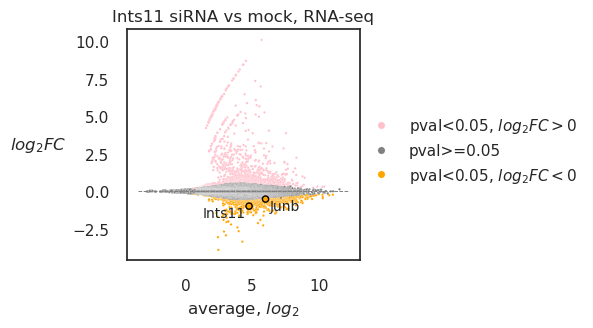

In [443]:
thr_significance = 0.05
TSSs_of_interest = {'Junb;85705347':'Junb','Ints11;155954003':'Ints11'}
batch = 'public'

DE_table = pd.read_csv(res_dict[batch],delimiter="\t",index_col=None,header=0)
DE_table['log2FoldChange'] = DE_table['log2FoldChange'].fillna(0)
DE_table[['pvalue','padj']] = DE_table[['pvalue','padj']].fillna(1)
DE_table['FDR'] = multipletests(DE_table['pvalue'],method = 'fdr_bh')[1]
DE_table['sign'] = (DE_table['pvalue']<thr_significance).astype('int')
map_dict = {-1:'pval<'+str(thr_significance)+', $log_2FC<0$',1:'pval<'+str(thr_significance)+', $log_2FC>0$',0:'pval>='+str(thr_significance)}
DE_table['RNAseq_cat'] = (DE_table['sign']*((DE_table['log2FoldChange']>0).astype('int')*2-1)).map(map_dict)
DE_table['log2_mean'] = np.log2(DE_table['baseMean'])
DE_table = DE_table.rename(columns={'gene_name':'TSS'})

data = DE_table.copy()
data_to_show = data.loc[data['TSS'].isin(TSSs_of_interest)].reset_index(drop=True)

x_feature,y_feature,hue = 'log2_mean','log2FoldChange','RNAseq_cat'
hue_order = ['pval<'+str(thr_significance)+', $log_2FC>0$','pval>='+str(thr_significance),'pval<'+str(thr_significance)+', $log_2FC<0$']
palette = ['pink','grey','orange']

sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(1, 1, sharey=False, sharex=False, figsize=(3,3),)

ax = sns.scatterplot(data = data,x=x_feature,y=y_feature,hue=hue,s=3,hue_order = hue_order,palette = palette)
ax = sns.scatterplot(data = data_to_show,x=x_feature,y=y_feature,hue=hue,s=20,edgecolor='black',linewidth=1,hue_order = hue_order,palette = palette,
                     alpha=1,legend=None)

for index, row in data_to_show.iterrows():
    if TSSs_of_interest[row['TSS']]=='Junb':
        ax.text(row[x_feature]*1.05,row[y_feature],TSSs_of_interest[row['TSS']],ha='left',va='top',size=10)
    else:
        ax.text(row[x_feature]*0.95,row[y_feature],TSSs_of_interest[row['TSS']],ha='right',va='top',size=10)
    
ax.set(xlabel = 'average, $log_2$',title='Ints11 siRNA vs mock, RNA-seq')
ax.set_ylabel(ylabel=r'$log_2FC$',rotation=0,ha='right',va='center',rotation_mode='anchor')
ax.hlines(y=0,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[1],color='grey',linestyles='--',linewidth=0.7)

ax.legend(bbox_to_anchor=(1.001, 0.65),loc=2,borderaxespad=0.0,title='',markerscale=3)

out = subprocess.check_output('mkdir -p '+subdirs['figures_dir']+'RNAseq/', shell=True)
fig.savefig(subdirs['figures_dir']+'RNAseq/MA_plot.png',bbox_inches='tight',dpi=600)
fig.savefig(subdirs['figures_dir']+'RNAseq/MA_plot.pdf',bbox_inches='tight',dpi=600)

In [ ]:
### Intersect

In [444]:
data.loc[data['TSS'].str.contains('Jun')]

,TSS,baseMean,log2FoldChange,pvalue,padj,FDR,sign,RNAseq_cat,log2_mean
122,Jun;94940459,44.898417,1.991924,2.390457e-07,0.000019,0.000042,1,"pval<0.05, $log_2FC>0$",5.488593
1169,Junb;85705347,64.194333,-0.519221,1.304064e-02,0.111358,0.240527,1,"pval<0.05, $log_2FC<0$",6.004374
2677,Jund;71151599,189.288310,-0.235770,1.072367e-01,0.399771,0.815808,0,pval>=0.05,7.564442


In [ ]:


pivot = pd.pivot_table(df,index=['TSS','chr','strand'],columns='segment',values = samples_list).reset_index()
columns = []
for elem in pivot.columns:
    columns.append(';'.join(elem) if elem[1]!='' else elem[0])
pivot.columns = columns

In [464]:
samples_ints11 = ['Ints11C_replicate5','Ints11C_replicate6']
samples_ints10 = ['Ints10N_replicate1','Ints10N_replicate2']
samples_back = ['RBC_exp17','RBC_exp18']

common_TSS['Ints11'] = ((common_TSS[samples_ints11].sum(axis=1)==2)&(common_TSS[samples_back].sum(axis=1)==0)).astype('int')
common_TSS['Ints10'] = ((common_TSS[samples_ints10].sum(axis=1)==2)&(common_TSS[samples_back].sum(axis=1)==0)).astype('int')

In [465]:
common_TSS.head()

,gene_name,Ints11C_replicate5,Ints11C_replicate6,Ints10N_replicate1,Ints10N_replicate2,RBC_exp17,RBC_exp18,SRR11551259,SRR11551260,SRR11551261,SRR11551262,Ints11,Ints10
0,A1BG,0,0,0,0,0,0,0,0,0,0,0,0
1,A1CF,0,0,0,0,0,0,0,0,0,0,0,0
2,A2M,0,0,0,0,0,0,0,0,0,0,0,0
3,A2ML1,0,0,0,0,0,0,0,0,0,0,0,0
4,A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0


In [463]:
common_TSS.loc[common_TSS['Ints11']==1]

,gene_name,Ints11C_replicate5,Ints11C_replicate6,Ints10N_replicate1,Ints10N_replicate2,RBC_exp17,RBC_exp18,SRR11551259,SRR11551260,SRR11551261,SRR11551262,Ints11
72,ABHD12,1,1,1,1,0,0,0,0,0,0,1
80,ABHD17A,1,1,1,1,0,0,0,0,0,0,1
91,ABI1,1,1,1,1,0,0,0,0,0,0,1
92,ABI2,1,1,1,1,0,0,0,0,0,0,1
97,ABL2,1,1,1,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16170,ZFAND5,1,1,1,1,0,0,0,0,0,0,1
16173,ZFC3H1,1,1,1,0,0,0,0,0,0,0,1
16183,ZFP36L1,1,1,1,1,0,0,0,0,0,0,1
16251,ZMYND8,1,1,1,0,0,0,0,0,0,0,1


In [283]:
data.loc[data['TSS'].str.contains('')]

,TSS,chr,strand,average_log2,lfc,pval,FDR,sign
21629,Id1;152578171,chr2,+,2.0,2.0,0.125,1.0,FDR>=0.05


In [159]:
pivot.loc[pivot['TSS'].str.contains('Jun')]

,TSS,chr,strand,Ints10N_replicate1;control_up,Ints10N_replicate1;signal,Ints10N_replicate2;control_up,Ints10N_replicate2;signal,Ints11C_replicate5;control_up,Ints11C_replicate5;signal,Ints11C_replicate6;control_up,...,Ints10N_replicate1;average_log2,Ints10N_replicate2;pval,Ints10N_replicate2;lfc,Ints10N_replicate2;average_log2,RBC_exp17;pval,RBC_exp17;lfc,RBC_exp17;average_log2,RBC_exp18;pval,RBC_exp18;lfc,RBC_exp18;average_log2
23017,Jun;94940459,chr4,-,0,29,0,12,0,4,0,...,4.906891,2.441406e-04,3.700440,3.700440,1.0,0.0,0.0,1.0,0.0,0.0
23018,Junb;85703171,chr8,-,4,6,1,2,2,1,5,...,3.459432,5.000000e-01,0.584963,2.000000,0.5,1.0,1.0,1.0,-1.0,1.0
23019,Junb;85705347,chr8,-,1,45,1,54,1,19,0,...,5.554589,1.554312e-15,4.781360,5.807355,1.0,0.0,0.0,1.0,0.0,0.0
23020,Jund;71151599,chr8,+,19,90,21,60,9,44,21,...,6.781360,8.467916e-06,1.471306,6.357552,1.0,0.0,0.0,0.5,1.0,1.0


In [5]:
# we use not all samples, only good ones
experimental_bCLIP_samples = pd.read_csv(subdirs['metadata_dir']+'experimental_bCLIP_samples.tsv',delimiter="\t",index_col=None,header=0)
public_bCLIP_and_ChipSeq_samples = pd.read_csv(subdirs['metadata_dir']+'public_bCLIP_and_ChipSeq_samples.tsv',delimiter="\t",index_col=None,header=0)

samples_to_analyze = ['11C_exp17','11C_exp18','RBC_exp17','RBC_exp18','Ints11C_replicate5','Ints11C_replicate6','Ints10N_replicate1','Ints10N_replicate2',
                      'NRDE2_replicate1_exp7','NRDE2_replicate2_exp8','NRDE2_replicate3_exp10','SRR15070630','SRR15070631']

In [6]:
experimental_bCLIP_samples.head()

,name,lane_name,lane_file,kmer,barcode_file,exp_ctl,batch,condition_name
0,Ints11C_replicate1,2143F1,2143F1-1_190822_D00404_0441_BCDR7LANXX_Undeter...,NNNN,barcodes_2143F1.fasta,exp,old,Ints11C
1,Ints11C_replicate2,2143F1,2143F1-1_190822_D00404_0441_BCDR7LANXX_Undeter...,NNNN,barcodes_2143F1.fasta,exp,old,Ints11C
2,Ints11C_replicate3,2161F1,2161F1-1_190924_D00404_0445_BCDY9VANXX_Undeter...,NNNN,barcodes_2161F1.fasta,exp,old,Ints11C
3,Ints11C_replicate4,2161F1,2161F1-1_190924_D00404_0445_BCDY9VANXX_Undeter...,NNNN,barcodes_2161F1.fasta,exp,old,Ints11C
4,Ints11C_replicate5,2533F1,2533F1-1_200814_D00404_0489_ACECNWANXX_Undeter...,NNNN,barcodes_2533F1.fasta,exp,old,Ints11C


In [4]:
input_samples = pd.read_csv(file_paths['input_samples'],delimiter="\t",index_col=None,header=0)
input_samples = input_samples.rename(columns={'name':'sample'})
input_samples = input_samples.loc[~input_samples['sample'].isin(samples_to_exclude_from_analysis)].reset_index(drop=True)

metadata = input_samples.copy()
metadata['group_1'] = metadata.apply(lambda x: x['lane_name'] if x['kmer']=='NNNN' else x['batch'],1)
metadata['group_2'] = metadata['exp_ctl'] # group_1 x group_2 are used to block into subplots, and group_3 is on the x axis + color
metadata['group_3'] = metadata['condition_name']
group_1_order = ['f230802','f230126','f230117','f20220722','f220407','f2533F1','f2161F1','f2143F1','public_bCLIP_mESC','public_eCLIP_Hela']
group_2_order = ['exp','neg_ctl','ctl']
group_3_order = ['Ints11C','Ints11N','Ints10C','Ints10N','Ints1N','Ints11','NRDE2','Nrde2_D174Rmut','NRDE2_200AANenddel','HP1','RBC','XRN1','N4BP2C','Ccdc174','Eif4a3','Mtrex','Ints11_SMInput','Igg']

color_list = ['orange','gold','green','lime','violet','purple','blue','royalblue','cyan','grey','grey','grey','grey','grey','grey','grey','grey','grey']

metadata = pd.merge(metadata,pd.DataFrame([group_3_order,color_list]).transpose().rename(columns={0:'group_3',1:'color'}),how='inner',on='group_3')
metadata['group_1_x_group_2'] = metadata['group_1']+'-'+metadata['group_2']

gr = metadata[['group_1','group_2','group_3']].drop_duplicates().reset_index(drop=True)
gr['t']=1
gr = gr.groupby(['group_1','group_2']).agg({'t':sum}).reset_index()
tmp = gr[['group_1','group_2']].values.tolist()

point_plots_width_ratios = []
group_1_x_group_2 = []
for element in itertools.product(*[group_1_order,group_2_order]):
    if list(element) in tmp:
        group_1_x_group_2.append(list(element))
        point_plots_width_ratios.append(gr.loc[(gr['group_1']==element[0])&(gr['group_2']==element[1])].iloc[0]['t'])
        
metadata['replicate'] = metadata.apply(lambda x: x['sample'] if x['batch'] not in ['public_bCLIP_mESC','public_eCLIP_Hela'] else x['condition_name']+'_'+x['sample'][-3:],1)